# Name: Kevin Jaku
# CID: 01492272

# Methods of Data Science - Coursework 2

In this notebook, we will be carrying out a set of classification tasks on the following 2 datasets:
- A set of images (task 1)
- A social network of Zachary's karate club (task 2)

I will carry out these tasks by building on the algorithms discussed in the lectures notes and exercises in order to implement them.

For task 1, I will focus on two types of neural networks: 
- Multi-layer perceptrons (task 1.1)
- Convolutional neural networks (task 1.2) 

For both of these networks I will use the training sets to train the model and then run the max-trained model on the validation set in order to obtain results I can use to analyse the performance of my networks. The architecture of the neural networks will be described in their corresponding sections. 

For task 2, I will carry out a range of tasks which are:
- Clustering my feature matrix (task 2.1)
- Dimensionality reduction on my feature matrix (task 2.2)
- Graph-based analysis (task 2.3)

I will implement the k-means algorithm to cluster my feature matrix and obtain a Calinski-Harabasz score which I will use to understanding the robustness of my clusterings. I will then implement principle component analysis (PCA) to see what is the optimal dimension to reduce our feature matrix to. Finally, I will use graph-baased analysis (GBA) in order to obtain clusterings and then compare these to the clusters obtained through the k-means algorithm using the adjusted rand index (ARI).

I will start by importing the relevant packages that required throughout this notebook to complete the tasks, these are as follows:
- NumPy 
- NetworkX 
- TensorFlow 
- MatplotLib 
- SciPy (alongside some specific functions within SciPy)

In [128]:
import numpy as np
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd

from scipy.spatial.distance import cdist
from scipy.sparse import linalg

I will now load the dataset that we will use in task 1, this is a collection of 2D images that use 3 colour channels (each image is 32 x 32 pixels), as a result each image has size 32 x 32 x 3. The training dataset has 50,000 of these images and the validation dataset has 10,000 of these images, so our datasets have the following dimensions:
- Training dataset: 50000 x 32 x 32 x 3
- Validation dataset: 10000 x 32 x 32 x 3

In order to be able to use this data in NumPy, I will have to flatten it from (50000, 32, 32, 3) to (50000, 3072) - where 32 x 32 x 32 = 3072. I will flatten the data later in this way and will state this again before I do it. Here I will just shuffle the data to avoid having unbalanced datasets and sort it into batches of 128 data points, this handling of the data is done specifically for CNN so that I can run this type of network on batches of the desired size later on in the notebook. I will handle the data slightly differently for MLP and will do this later on, in that section.

In [129]:
# Use tensorflow to load the data as specified in the coursework question sheet
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()

# Load the data into dataset objects, shuffle and separate into batches as explained above
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(50000)
train_data = train_data.batch(128)

val_data = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
val_data = val_data.shuffle(10000)
val_data = val_data.batch(128)

# Task 1: Neural Networks

Neural networks form the basis of deep learning, and their algorithms are inspired by the biological neurons in the human brain. Neural networks take in data, train themselves on this data by updating the network parameters at each iteration and then predict the outputs. This training is done on the training set and then these updated, max-trained parameters are then tested on the validation set. Neural networks are made up of hidden layers (which includes the input layer) and an output layer. The input layer receives the input, the output layers predict the final output, and inbetween these are the hidden layers which are made up of neurons which we train by updating our network paramters, this training is done by through forward- and back-propagation at each iteration. Once max-trained, these neural networks can be used to output very accurate predictions in classification tasks and have been used in the real world for things like facial recognition.


## 1.1 Multi-Layer Perceptron (MLP)

The MLP is a type of neural network model, that consists of an input layer, an output layer and hidden layers between these. Each hidden layer and in some case the output layer have an activation function. These hidden layers take in input, multiply them by weights and then add a bias and as this onto the next layer as input. This is shown below for which we denote the hidden layers as: ${h}^{(k)}$ for $k=0,\ldots, L$ (where ${h}^{(0)}$ is the input layer) and the output layer as: $\hat{\boldsymbol{y}}$...

$$
\begin{align}
\boldsymbol{h}^{(0)} &= \boldsymbol{x} \\
\boldsymbol{h}^{(k)} &= \sigma\left((\boldsymbol{h}^{(k-1)})^T \boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)} \right) \qquad k=1,\ldots, L \\
\hat{\boldsymbol{y}} &= \sigma_{out}\left((\boldsymbol{h}^{(L)})^T \boldsymbol{W}^{(L)} + \boldsymbol{b}^{(L)} \right) 
\end{align}
$$

Here, $\boldsymbol x\in\mathbb{R}^D$ are the inputs, $\hat{\boldsymbol{y}}\in\mathbb{R}^{n_{L+1}}$ are the outputs, $L$ is the number of hidden layers in the model, $\boldsymbol{W}^{(k)}\in\mathbb{R}^{n_{k}\times n_{k+1}}$ is the kernel matrix consisting of the weights that we will update, $\boldsymbol{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ are the biases, $\boldsymbol{h}^{(k)}\in\mathbb{R}^{n_k}$ are the outputs from the hidden layers - where $n_k$ is the number of neurons in the $k^{th}$ hidden layer, and we have set $n_0 := D$ - which corresponds to the size of the dataset. Furthermore, $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ are activation functions for the hidden layers and for the output layer respectively - and they operate element-wise.
$$
$$

### Part 1.1.1

I will build the MLP model just using NumPy to train on the flattened images dataset. The architecture of the network we will use for this task is as follows:

- 5 hidden layers (including the input layer) with 400 neurons each, with activation function: $\sigma(x) = tanh(x)$
- Output layer with 10 neurons, with activation function: $\sigma_{out}(x) = softmax(x)_{i}$

where the $softmax$ function is as follows: $\sigma_{out}(x)_{i} = \frac{e^{x_{i}}}{\sum_{j=1}^{L} e^{x_{j}}}$, this normalization ensures that the sum of the components of the output vector $\sigma_{out}(x)$ is 1 as these outputs represent the probabilities of the input falling into a specific class, the highest probability is then chosen and the network says the input (image) to that class.

For our MLP, the optimisation method will be stochastic gradient descent (SGD) and the loss function will be cross-entropy. SGD requires us to perform gradient descent which is linear regression problem with the objective of minimizing the sum of squared residuals, which will allow us to update our kernels and biases which will reduce our loss. The 'stochastic' bit becomes from the fact that we are applying gradient descent to randomly selected (since we shuffled the data) subsets (our batches of 128 data points) of the data. The cross-entropy loss function is a function that allows us to find the loss between our network's output and the data that this output was meant to be predicting, it does this in the way defined in my 'cross_ent_loss()' function below.

I will now define a series of function that I will need when implementing my MLP network:

In [602]:
# This dense function will form the hidden layers which will do as described above
def dense(x, W, b):
   
    h = b + x @ W
    return h

My activation functions will be the standardised $tanh$ function for my hidden layers and the $softmax$ function for my output layer. We will use the inbuilt NumPy $tanh$ function for the hidden layers, but for my output layer I will define a $softmax$ function as follows:

In [614]:
# This code allows me to implement the softmax function that I described above 
def softmax_fn(x):
    x_trans = x.T
    e_x = np.exp(x_trans - np.max(x_trans))
    return (e_x / e_x.sum(axis = 0)).T

The loss between the output from my MLP network $\hat{y}$ and the value that I am trying to predict $y_{train}$ will be calculated by cross-entropy loss. These losses are the losses I will obtain and store for each iteration, and once an epoch has run through all iterations, I will define the loss for that epoch to be the mean of all these cross entropy losses for each iteration. Cross entropy loss has the following formula:
$$
\textit{Cross-entropy loss} = \frac{1}{M} \sum_{i = 1}^{M} y^{(i)}_{train}(log(\hat{y}^{(i)}))
$$
where $M$ is the batch size (in our case $M$ = 128), $y^{(i)}_{train}$ is our $y_{train}$ from the dataset and $\hat{y}^{(i)}$ is the output from our forward propagation.

 I implemented this with the following function.

In [130]:
def cross_ent_loss(predicted, target):
    N = predicted.shape[0]
    # Add a very small value 1e-9 just to ensure we are never putting zero into the log function
    ce_loss = -np.sum(target * np.log(predicted + 1e-9)) / N
    return ce_loss

The accuracy of the output from my MLP network $\hat{y}$ against the value that I am trying to predict $y_{train}$ will be calculated by the accuracy function that I defined below. It uses argmax and the equality operator in order to obtain a final accuracy. Just like with the losses, these accuracies are the accuracies I will obtain and store for each iteration, and once an epoch has run through all iterations, I will define the accuracy for that epoch to be the mean of all these accuracies for each iteration. I implemented the following accuracy function:

In [131]:
def get_acc(A, B):
    a = np.argmax(A, axis = 1)
    b = np.argmax(B, axis = 1)
    total = 0
    for i in range(A.shape[0]):
        if a[i] == b[i]:
            total += 1
    accuracy = total / A.shape[0]
    return accuracy

I will now look a little deeper into how we will run the forward propagation of my MLP network and why we do this. Let's reconsider the layers of my MLP model and look at the kernels and biases in particular. From the lecture notes, we know that MLP algorithm will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$
* The dimensions here come from the fact that my input x has dimension (50000, 3072) after flattening and I want 400 neurons in my hidden layers

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{400\times 400}$, $k=1, 2, 3, 4$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{400}$, $k=1, 2, 3, 4$
* The dimensions here come from the fact that we want 400 neurons in our hidden layers

Output layer -> final layer:
* Kernel $\boldsymbol{W}^{(5)} \in\mathbb{R}^{400\times 10}$
* Bias $\boldsymbol{b}^{(5)} \in\mathbb{R}^{10}$
* The dimensions here come from the fact that my output is receiving an input of size 400 and I want 10 neurons in my output layers

I will create these parameters as NumPy arrays, and initialise the kernel and bias values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation] - see references at the bottom. I will initialise these parameters later on in my actual 'MLP_SGD()' function.  

Forward propagation allows us to obtain $h^{k}$ for $k = 0, 1, 2, 3, 4, 5$ which are the outputs of my hidden layers (called post-activations) and the final output $y_{hat}$. Using $y_{hat}$ I can find my output error, which is just the difference between $y_{hat}$ and what I am trying to predict with my model which is $y_{train}$. This output error is the used to find $\delta^{6}$ which is what I need to then start my back propagation, which I will move onto after testing my MLP function quickly.

I will now quickly implement a very basic MLP testing function just to ensure this network runs and that the outputs (which are probabilities) have indeed been normalised by the $softmax$ function so that once outputted, they sum to 1. This MLP function will not be called in my actual 'MLP_SGD()' function when I run the epochs, but it is just to check that what I have so far is performing as it should. It uses my dense function to create the layers, each of which have their appropriate corresponding activation functions.

In [132]:
def mlp_test(x):
    a1 = dense(h0, W0, b0)
    h1 = np.tanh(a1)
    a2 = dense(h1, W1, b1)
    h2 = np.tanh(a2)
    a3 = dense(h2, W2, b2)
    h3 = np.tanh(a3)
    a4 = dense(h3, W3, b3)
    h4 = np.tanh(a4)
    a5 = dense(h4, W4, b4)
    h5 = np.tanh(a5)
    y = dense(h5, W5, b5)
    y_hat = softmax_fn(y)
    
    return y_hat

Using this function, I can see that all of my probabilities sum to 1, so my output makes sense and I can proceed.

In [684]:
# Get the output of my MLP testing network to check that my outputs are correct
y_hat_test = mlp_test(x_train)
# Check that probabilities sum to 1 for some random images out of the batch of 128 data points
print(np.sum(y_hat_test[15, :]))
print(np.sum(y_hat_test[43, :]))
print(np.sum(y_hat_test[79, :]))
print(np.sum(y_hat_test[103, :]))

1.0
1.0
1.0
1.0


Now that I have finished with the forward propagation part of my MLP network, I can proceed with explaining why we now need back propagation and implement the relevant functions in order to be able to code this part of the MLP algorithm. From the lecture notes, we know that the backpropagation algorithm can be summarised as follows:

* Find the first error $\delta^{(6)} := \mathcal{L}(y_{hat}, y_{train})$ where we denote $\mathcal{L}$ as the cross-entropy loss function 
* Using $\delta^{(6)}$, kernels $W^{(k)}$ and post-activations $h^(k)$ for $k=1, 2, 3, 4, 5$, carry out back propagation to find the remaining deltas: $\delta^{(i)}$ for $i=1, 2, 3, 4, 5$.
* Perform gradient descent and obtain values $W^{k}_{grad}$ and $b^{k}_{grad}$ for $k = 0, 1, ..., 5$ to then update the kernels and biases, respectively.

To calculate $\delta^{(6)}$ as defined above, we need the following output error function which is a very basic function that uses minibatch loss, which involves finding the difference between $y_hat$ and $y_train$ and then scaling by a factor of $\frac{1}{M}$ where $M$ is the size of the batch, in our case it will be M = 128. This will allow us to start our back propagation alogrithm:

In [689]:
def output_error(y, a):
    
    return (a - y) / y.shape[0]

Once I have my first $\delta$ which will be $\delta^{6}$, I can use back propagation to work backwards to find the rest of my deltas which are: $\delta^{5}$, ..., $\delta^{1}$. Before I define my back propagation function, I need to define the activation derivative which is just the derivative of the hidden layer activation function $tanh$, this is done as we want to minimise our loss. The derivative of $tanh$ is just 1 - $tanh^{2}$:

In [ ]:
def activation_derivative(a1):
    
    return 1 - np.square(np.tanh(a1))

Now I am able to define my back propagation function which is the following:

In [ ]:
def back_prop(delta, W, a):
    
    W_delta = W @ delta.T
    delta_star = activation_derivative(a) * W_delta.T
    return delta_star

After I find all my $\delta^{k}$ for $k = 1, 2, ..., 6$, I can then use these $\delta^{k}$ and the post-activations $h^{i}$ for $i = 0, 1, ..., 5$ from our forward propagation algorithm in order to perform gradient descent and obtain values $W^{k}_{grad}$ and $b^{k}_{grad}$ for $k = 0, 1, ..., 5$ which I will use to update my kernels and biases, respectively. This is the whole point of the back propagation algorithm as it allows me to train my MLP network by updating my kernels and biases.

In [688]:
def grads(delta1, delta2, delta3, delta4, delta5, delta6, h0, h1, h2, h3, h4, h5):
    
    grad_W0 = (delta1.T @ h0).T
    grad_b0 = delta1
    grad_W1 = (delta2.T @ h1).T
    grad_b1 = delta2
    grad_W2 = (delta3.T @ h2).T
    grad_b2 = delta3
    grad_W3 = (delta4.T @ h3).T
    grad_b3 = delta4
    grad_W4 = (delta5.T @ h4).T
    grad_b4 = delta5
    grad_W5 = (delta6.T @ h5).T
    grad_b5 = delta6
    
    grad_b0 = np.mean(grad_b0, axis=0)
    grad_b1 = np.mean(grad_b1, axis=0)
    grad_b2 = np.mean(grad_b2, axis=0)
    grad_b3 = np.mean(grad_b3, axis=0)
    grad_b4 = np.mean(grad_b4, axis=0)
    grad_b5 = np.mean(grad_b5, axis=0)
    grad_b5 = np.mean(grad_b5, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4, grad_W5, grad_b5

I will handle the data here by first flattening it, then shuffling it and then shaving off the last 80 dataset points so that I am able to run 390 iterations on different batches of size 128 (as 390 x 128 = 49920). This will not significantly impact my network but will ensure that I do not run into any dimension errors. I do these steps for both the training and validation datasets but for the validation dataset I shave off the last 16 dataset points so that I am able to run 78 iterations on different batches of size 128 (as 78 x 128 = 9984). Now, the training and validation datasets are ready for me to run my MLP network on.

In [673]:
x_train = np.reshape(x_train, (x_train.shape[0], 3072))
train_data = np.concatenate((x_train, y_train), axis = 1)
np.random.shuffle(train_data)
train_data = train_data[:49920, :]
train_data1 = np.split(train_data, 390)

x_val = np.reshape(x_val, (x_val.shape[0], 3072))
val_data = np.concatenate((x_val, y_val), axis = 1)
np.random.shuffle(val_data)
val_data = val_data[:9984, :]
val_data1 = np.split(val_data, 78)

Finally, I will implement all of the theory explained above in order to create my 'MLP_SGD()' function which will call most of the functions that I have defined above. It will take as inputs the number of epochs and the desired learning rate, and output the losses and accuracies for both the training and validation datasets.

In [699]:
# Define a function that implements MLP with SGD as the optimizer and lets me choose the learning rate and 
# number of epochs
def MLP_SGD(epochs, learning_rate):
    
    # Define the number of iterations that will I use
    iter_train = 390
    iter_val = 78
    
    # Initialise the parameters, these will then be updated after each iteration
    var0 = 2. / (400 + 3072)
    W0 = np.random.randn(3072, 400) * np.sqrt(var0)
    b0 = np.zeros(400)

    var1 = 2. / (400 + 400)
    W1 = np.random.randn(400, 400) * np.sqrt(var1)
    b1 = np.zeros(400)

    var2 = 2. / (400 + 400)
    W2 = np.random.randn(400, 400) * np.sqrt(var2)
    b2 = np.zeros(400)

    var3 = 2. / (400 + 400)
    W3 = np.random.randn(400, 400) * np.sqrt(var3)
    b3 = np.zeros(400)

    var4 = 2. / (400 + 400)
    W4 = np.random.randn(400, 400) * np.sqrt(var4)
    b4 = np.zeros(400)

    var5 = 2. / (10 + 400)
    W5 = np.random.randn(400, 10) * np.sqrt(var5)
    b5 = np.zeros(10)
    
    # Preallocate the losses and accuracies over an entire epoch for the training and validation sets
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Keep track of the epochs
        print('Epoch:', epoch + 1)
        
        # Preallocate the losses and accuracies over an entire iteration for the training set
        train_batch_losses = []
        train_batch_accuracies = []
        
        for i in range(iter_train):
            x_train_batch = train_data1[i][:, :3072]
            h0 = x_train_batch
            y_train_batch = train_data1[i][:, 3072:]

            # Apply the forward propagation step to obtain h's and y_hat
            a1 = dense(h0, W0, b0)
            h1 = np.tanh(a1)
            a2 = dense(h1, W1, b1)
            h2 = np.tanh(a2)
            a3 = dense(h2, W2, b2)
            h3 = np.tanh(a3)
            a4 = dense(h3, W3, b3)
            h4 = np.tanh(a4)
            a5 = dense(h4, W4, b4)
            h5 = np.tanh(a5)
            y = dense(h5, W5, b5)
            y_hat = softmax_fn(y)
        
            # Calculate the loss using cross entropy then find the respective losses and accuracies and updating the
            # preallocations
            # Calculate the error to find delta6 to start back propagation
            train_batch_loss = cross_ent_loss(y_hat, y_train_batch)
            train_batch_losses.append(train_batch_loss)
            train_batch_accuracy = get_acc(y_hat, y_train_batch)
            train_batch_accuracies.append(train_batch_accuracy)
            del6 = output_error(y_train_batch, y_hat)
        
            # Use back propagation to calculate the deltas
            del5 = back_prop(del6, W5, a5)
            del4 = back_prop(del5, W4, a4)
            del3 = back_prop(del4, W3, a3)
            del2 = back_prop(del3, W2, a2)
            del1 = back_prop(del2, W1, a1)
        
            # Feed the h's from forward propagation and deltas from back propagation to obtain values that I will 
            # then use to update our kernels and biases
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4, grad_W5, grad_b5 = grads(del1, del2, del3, del4, del5, del6, h0, h1, h2, h3, h4, h5)
        
            # Update kernels and biases
            b0 -= learning_rate * grad_b0
            b1 -= learning_rate * grad_b1
            b2 -= learning_rate * grad_b2
            b3 -= learning_rate * grad_b3
            b4 -= learning_rate * grad_b4
            b5 -= learning_rate * grad_b5

            W0 -= learning_rate * grad_W0
            W1 -= learning_rate * grad_W1
            W2 -= learning_rate * grad_W2
            W3 -= learning_rate * grad_W3
            W4 -= learning_rate * grad_W4
            W5 -= learning_rate * grad_W5
            
        # Calculate the error using cross entropy then find the respective losses and accuracies and updating my
        # preallocations
        train_losses.append(np.mean(train_batch_losses))
        print('Training loss after this epoch', np.mean(train_batch_losses))
        train_accuracies.append(np.mean(train_batch_accuracies))
        print('Training accuracy after this epoch', np.mean(train_batch_accuracies))
        
# Now to use these updated kernels and biases on the validation set
        
    
        # Preallocate the losses and accuracies over an entire iteration for the validation set
        val_batch_losses = []
        val_batch_accuracies = []
        
        for i in range(iter_val):            
            # Define the batches of 128 data points
            x_val_batch = val_data1[i][:, :3072]
            h0 = x_val_batch
            y_val_batch = val_data1[i][:, 3072:]
            
            # Apply the forward propagation step to obtain h's and y_hat
            a1 = dense(h0, W0, b0)
            h1 = np.tanh(a1)
            a2 = dense(h1, W1, b1)
            h2 = np.tanh(a2)
            a3 = dense(h2, W2, b2)
            h3 = np.tanh(a3)
            a4 = dense(h3, W3, b3)
            h4 = np.tanh(a4)
            a5 = dense(h4, W4, b4)
            h5 = np.tanh(a5)
            y = dense(h5, W5, b5)
            y_hat = softmax_fn(y)
    
            # Calculate the loss using cross entropy then find the respective losses and accuracies and updating the
            # preallocations
            # Calculate the error to find delta6 to start back propagation
            val_batch_loss = cross_ent_loss(y_hat, y_val_batch)
            val_batch_losses.append(val_batch_loss)
            val_batch_accuracy = get_acc(y_hat, y_val_batch)
            val_batch_accuracies.append(val_batch_accuracy)
            
        # Calculate the error using cross entropy then find the respective losses and accuracies and updating the
        # preallocations
        val_losses.append(np.mean(val_batch_losses))
        print('Validation loss after this epoch', np.mean(val_batch_losses))
        val_accuracies.append(np.mean(val_batch_accuracies))
        print('Validation accuracy after this epoch', np.mean(val_batch_accuracies))
    
    return train_losses, train_accuracies, val_losses, val_accuracies

I will now implement my 'MLP_SGD()' function with the epochs set to 40 and the learning rate set to 0.01 and see what values I obtain for the losses and accuracies for both the training and validation datasets.

In [700]:
train_losses1, train_accuracies1, val_losses1, val_accuracies1 = MLP_SGD(40, 0.01)

Epoch: 1
Training loss after this epoch 1.9355219909515353
Training accuracy after this epoch 0.3074519230769231
Validation loss after this epoch 1.845391531412282
Validation accuracy after this epoch 0.3278245192307692
Epoch: 2
Training loss after this epoch 1.7880937038118883
Training accuracy after this epoch 0.36606570512820513
Validation loss after this epoch 1.8086824194396958
Validation accuracy after this epoch 0.3407451923076923
Epoch: 3
Training loss after this epoch 1.7329984634031852
Training accuracy after this epoch 0.38719951923076923
Validation loss after this epoch 1.785955668761626
Validation accuracy after this epoch 0.34915865384615385
Epoch: 4
Training loss after this epoch 1.688486362880583
Training accuracy after this epoch 0.4046073717948718
Validation loss after this epoch 1.747365187642476
Validation accuracy after this epoch 0.36728766025641024
Epoch: 5
Training loss after this epoch 1.6511772848665358
Training accuracy after this epoch 0.4158253205128205
Val

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a learning rate of 0.01:

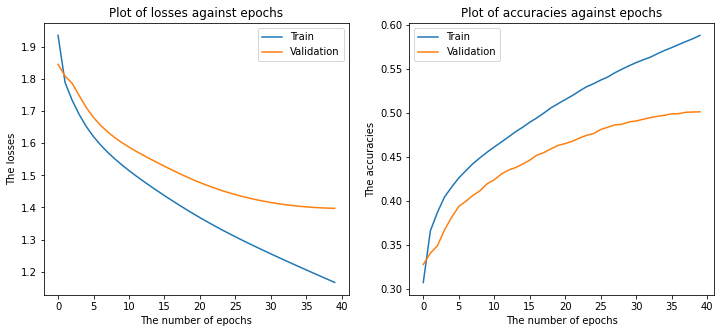

In [701]:
# Plot the learning curves
fig = plt.figure(figsize=(12, 5))

# Plot loss vs epoch
fig.add_subplot(121)
# Plot losses of training and validation sets
plt.plot(train_losses1, label = 'Train');
plt.plot(val_losses1, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The losses');
plt.title('Plot of losses against epochs');
plt.legend()


# Plot accuracy vs epoch
fig.add_subplot(122)
plt.plot(train_accuracies1, label = 'Train');
plt.plot(val_accuracies1, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The accuracies');
plt.title('Plot of accuracies against epochs');
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training loss starts off rapidly decreasing but does not look to be converging and seems to be tending towards a linear function while the validation loss starts off decreasing quite quickly but seems to be converging, it seems as though if we were to run this for more epochs the training and validation losses would continue to diverge. The training loss is at 1.2 after 40 epochs but as stated before does not seem to be converging at all and the validation loss is converging to 1.4. Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy starts off rapidly increasing but again does not seem to be converging and seems to be tending again to a linear function while the validation accuracy starts off increasing fairly quickly but seems to be converging or maybe a maximum. The training accuracy is at 60% after 40 epochs but as stated before does not seem to be converging at all and the validation accuracy is converging to 50%. Here we have overfitting because the MLP network performs worse on the validation dataset compared to the training dataset and so the MLP network is not generalisable and prone to high variation for a new dataset.

### Part 1.1.2

I will now implement my 'MLP_SGD()' function with the epochs set to 40 again, but this time with the learning rate set to 0.0001 and see how a lower learning rate impacts the values I obtain for the losses and accuracies for both the training and validation datasets.

In [702]:
train_losses2, train_accuracies2, val_losses2, val_accuracies2 = MLP_SGD(40, 0.0001)

Epoch: 1
Training loss after this epoch 2.3275697189785327
Training accuracy after this epoch 0.11043669871794871
Validation loss after this epoch 2.2944069367729147
Validation accuracy after this epoch 0.12810496794871795
Epoch: 2
Training loss after this epoch 2.280950881872569
Training accuracy after this epoch 0.14419070512820512
Validation loss after this epoch 2.267327244960877
Validation accuracy after this epoch 0.16917067307692307
Epoch: 3
Training loss after this epoch 2.255840174425377
Training accuracy after this epoch 0.1756209935897436
Validation loss after this epoch 2.24402820421246
Validation accuracy after this epoch 0.20072115384615385
Epoch: 4
Training loss after this epoch 2.233067981781217
Training accuracy after this epoch 0.20028044871794873
Validation loss after this epoch 2.2223084999133356
Validation accuracy after this epoch 0.22205528846153846
Epoch: 5
Training loss after this epoch 2.2116763517783995
Training accuracy after this epoch 0.2206330128205128
Va

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a lower learning rate of 0.0001:

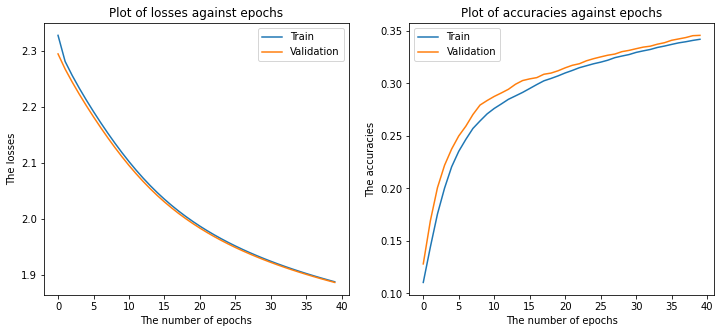

In [703]:
# Plot the learning curves
fig = plt.figure(figsize=(12, 5))

# Plot loss vs epoch
fig.add_subplot(121)
# Plot losses of training and validation sets
plt.plot(train_losses2, label = 'Train');
plt.plot(val_losses2, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The losses');
plt.title('Plot of losses against epochs');
plt.legend()


# Plot accuracy vs epoch
fig.add_subplot(122)
plt.plot(train_accuracies2, label = 'Train');
plt.plot(val_accuracies2, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The accuracies');
plt.title('Plot of accuracies against epochs');
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training loss and validation loss behave very similarly, they both start off decreasing but do seem to be slowly converging. The training and validation loss are starting to converge and seem as though they will go down to the range (1.8, 1.85). Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy and validation accuracy also behave very similarly, they both start off increasing but do seem to be converging. The training and validation accuracy are starting to converge to 35%. Here we have do not have overfitting because the MLP network performs almost the same on the training and validation datasets, so the MLP network is generalisable and not prone to high variation for a new dataset, however the accuracies are quite low so the MLP network does not perform too well. The difference now is that we have convergence and no overfitting, but the performance of the MLP network has significantly suffered.

I will now implement my 'MLP_SGD()' function with the epochs set to 40 again, but this time with the learning rate set to 0.1 and see how a higher learning rate impacts the values I obtain for the losses and accuracies for both the training and validation datasets.

In [704]:
train_losses3, train_accuracies3, val_losses3, val_accuracies3 = MLP_SGD(40, 0.1)

Epoch: 1
Training loss after this epoch 2.304457525935077
Training accuracy after this epoch 0.246474358974359
Validation loss after this epoch 1.9677319449563566
Validation accuracy after this epoch 0.2995793269230769
Epoch: 2
Training loss after this epoch 1.804627305920211
Training accuracy after this epoch 0.35098157051282053
Validation loss after this epoch 1.8919152366002459
Validation accuracy after this epoch 0.3378405448717949
Epoch: 3
Training loss after this epoch 1.7080969641446335
Training accuracy after this epoch 0.3879607371794872
Validation loss after this epoch 1.9198194794163879
Validation accuracy after this epoch 0.3379407051282051
Epoch: 4
Training loss after this epoch 1.6427701245902573
Training accuracy after this epoch 0.4109775641025641
Validation loss after this epoch 1.876054843131783
Validation accuracy after this epoch 0.35236378205128205
Epoch: 5
Training loss after this epoch 1.5884107747972056
Training accuracy after this epoch 0.4319110576923077
Valid

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a higher learning rate of 0.1

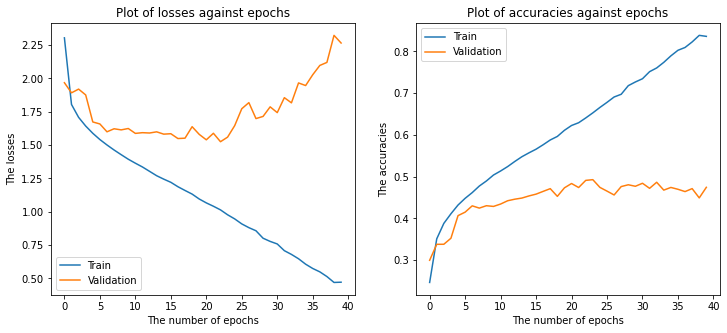

In [705]:
# Plot the learning curves
fig = plt.figure(figsize=(12, 5))

# Plot loss vs epoch
fig.add_subplot(121)
# Plot losses of training and validation sets
plt.plot(train_losses3, label = 'Train');
plt.plot(val_losses3, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The losses');
plt.title('Plot of losses against epochs');
plt.legend()


# Plot accuracy vs epoch
fig.add_subplot(122)
plt.plot(train_accuracies3, label = 'Train');
plt.plot(val_accuracies3, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The accuracies');
plt.title('Plot of accuracies against epochs');
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training loss starts off rapidly decreasing but does not look to be converging and seems to be tending towards a linear function again while the validation loss starts off decreasing slowly but then starts to increase again and massively diverge from the training losses. The training loss is at 0.5 after 40 epochs but as stated before does not seem to be converging at all and the validation loss is at 2.5 after 40 epochs but is quickly increasing. Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy starts off rapidly increasing but again does not seem to be converging and seems to be tending again to a linear function while the validation accuracy starts off increasing slowly but seems to be converging or maybe at maximum and will decrease after more epochs. The training accuracy is at 85% after 40 epochs but as stated before does not seem to be converging at all and the validation accuracy is converging to 45%.  Here we have massive overfitting because the MLP network performs much worse on the validation dataset compared to the training dataset and so the MLP network is not generalisable and prone to high variation for a new dataset. The difference now is that we have even less convergence and even more overfitting, but the performance of the MLP network on the training dataset has significantly improved while the performance of the MLP network on the validation dataset has significantly suffered.

### Part 1.1.3

I will now implement my 'MLP_SGD()' function with the epochs set to 80 this time, i.e. double what it was before and I will set the learning rate back down to 0.01 and see how an increase in the number of epochs impacts the values I obtain for the losses and accuracies for both the training and validation datasets.

In [706]:
train_losses4, train_accuracies4, val_losses4, val_accuracies4 = MLP_SGD(80, 0.01)

Epoch: 1
Training loss after this epoch 1.9476539001050885
Training accuracy after this epoch 0.30528846153846156
Validation loss after this epoch 1.8473547555917698
Validation accuracy after this epoch 0.3333333333333333
Epoch: 2
Training loss after this epoch 1.7889062545361338
Training accuracy after this epoch 0.3680288461538462
Validation loss after this epoch 1.799652091438956
Validation accuracy after this epoch 0.3501602564102564
Epoch: 3
Training loss after this epoch 1.7347050896443263
Training accuracy after this epoch 0.3881209935897436
Validation loss after this epoch 1.7683968351558486
Validation accuracy after this epoch 0.3618790064102564
Epoch: 4
Training loss after this epoch 1.692270957821313
Training accuracy after this epoch 0.4032051282051282
Validation loss after this epoch 1.7288731737811462
Validation accuracy after this epoch 0.37580128205128205
Epoch: 5
Training loss after this epoch 1.6554675510385837
Training accuracy after this epoch 0.4155849358974359
Val

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 80 epochs and a learning rate of 0.01

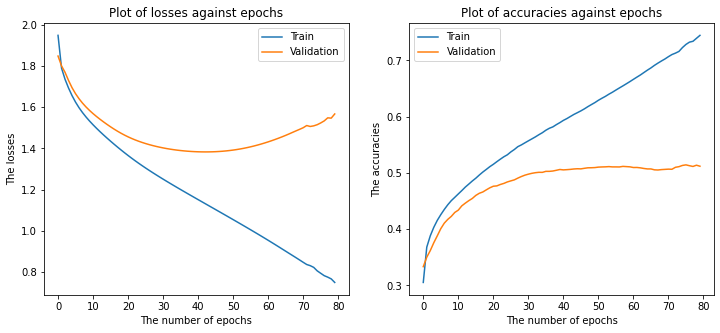

In [708]:
# Plot the learning curves
fig = plt.figure(figsize=(12, 5))

# Plot loss vs epoch
fig.add_subplot(121)
# Plot losses of training and validation sets
plt.plot(train_losses4, label = 'Train');
plt.plot(val_losses4, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The losses');
plt.title('Plot of losses against epochs');
plt.legend()


# Plot accuracy vs epoch
fig.add_subplot(122)
plt.plot(train_accuracies4, label = 'Train');
plt.plot(val_accuracies4, label = 'Validation');
plt.xlabel('The number of epochs');
plt.ylabel('The accuracies');
plt.title('Plot of accuracies against epochs');
plt.legend()

plt.show()

This case is very similar to the one with 40 epochs and a learning rate of 0.1. I will start with the losses, from the plot above on the left it is clear to see that the training loss starts off rapidly decreasing but does not look to be converging and seems to be tending towards a linear function again while the validation loss starts off decreasing fairly quickly but then starts to increase again and again massively diverge from the training losses. The training loss is at 0.75 after 80 epochs but as stated before does not seem to be converging at all and the validation loss is at 1.5 after 80 epochs but is quickly increasing. Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy starts off rapidly increasing but again does not seem to be converging and seems to be tending again to a linear function while the validation accuracy starts off increasing slowly but seems to be converging. The training accuracy is at 75% after 80 epochs but as stated before does not seem to be converging at all and the validation accuracy is converging to 50%.  Here we have massive overfitting because the MLP network performs much worse on the validation dataset compared to the training dataset and so the MLP network is not generalisable and prone to high variation for a new dataset. The difference now between this and 1.1.1, is that 1.1.3 is similar to the case is very similar to the one with 40 epochs and a learning rate of 0.1, is that we have even less convergence and even more overfitting, but the performance of the MLP network on the training dataset has significantly improved while the performance of the MLP network on the validation dataset has significantly suffered. To compare to 1.1.2, we see that this is like a balance between the two, as the case with 40 epochs and learning rate 0.0001 almost completely gets rid of overfitting but has very poor accuracies, while the case with 40 epochs and learning rate 0.1 has a lot of overfitting but very good accuracies, in comparison to 1.1.3, the case with 80 epochs and learning rate 0.01 which has an overfitting and accuracy between the two models just describe, so this seems to opt for balance rather than pure high accuracy or overfitting reduction.

## 1.2 Convolutional Neural Network (CNN)

CNNs are similar to MLPs, however they are regularized versions that used convolutional layers, we know that MLPs are 'fully-connected' networks which means that each neuron in one layer is connected to all neurons in the next layer. The 'fully-connected' nature of the MLP networks means this network is very prone to overfitting data, as seen in the section above.
These convolutional layers take advantage of the patterns in data and assemble patterns of increasing complexity using smaller and simpler patterns given by the filters. This makes CNNs very good at recognizing patterns in data and the pooling layers allow them to operate on raw images, meaning that the dataset does not need any preprocessing. CNNs have three main types of layers, which are:

* Convolutional layer (Conv2D) - use patterns in the data to assemble patterns of increasing complexity
* Pooling layer (MaxPool2D) -  conducts dimensionality reduction which reduces the number of parameters
* Fully-connected layer (Dense) - performs classification based on the features extracted through the previous layers

### Part 1.2.1

I will build the CNN model in TensorFlow to train on the images dataset. The architecture of the network we will use for this task is as follows:

* One Conv2D layer with 32 features maps of size 3x3, followed by two Conv2D layers with 64 features maps of size 3x3, all with $ReLU$ activation function
* A MaxPool2D between each Conv2D layer
* A Flatten layer to ensure we have the right input size for our next layer
* Two Dense layers, one which is just a fully-connected hidden layer with 64 neurons and $ReLU$ activation function and the other is the output layer with 10 neurons and $softmax$ activation function.
where the $ReLU$ activation function is just the 'rectified linear unit' activation function which has the following formula:
$$
ReLU(x) = max(0, x)
$$
As I am using TensorFlow to create this CNN, I do not need to define any functions as they are all already inbuilt into TensorFlow so I can go straight into creating a CNN that has the architecture as described above, which I do with the following code:

In [213]:
# Import the relevant TensorFlow modules and layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

# Define model as specified above
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

TensorFlow enables me to obtain a summary of my CNN model so that I can see if the model I created fits the desired architecture, it also shows me the number of parameters and the output shape of each layer, so that I can better understand my defined network

In [707]:
# Print the model summary

model_CNN_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

For this CNN, the required optimisation method is SGD (the same as explained in the MLP section) with a learning rate of 0.1 and the loss function is cross-entropy (again, the same as explained in the MLP section), so I will implement this into my CNN model now:

In [216]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

model_CNN.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Finally, I have defined my model to fit the required architecture along with SGD optimisation and cross-entropy loss, so now I will use TensorFlow to run it

In [217]:
history = model_CNN.fit(train_data, epochs=40, verbose=1, validation_data=val_data)

Epoch 1/40
391/391 [==============================] - 86s 221ms/step - loss: 2.0807 - accuracy: 0.2423 - val_loss: 1.8701 - val_accuracy: 0.3282
Epoch 2/40
391/391 [==============================] - 81s 208ms/step - loss: 1.6342 - accuracy: 0.4114 - val_loss: 1.6074 - val_accuracy: 0.4351
Epoch 3/40
391/391 [==============================] - 82s 211ms/step - loss: 1.4102 - accuracy: 0.4988 - val_loss: 1.2909 - val_accuracy: 0.5337
Epoch 4/40
391/391 [==============================] - 75s 192ms/step - loss: 1.2665 - accuracy: 0.5523 - val_loss: 1.3423 - val_accuracy: 0.5113
Epoch 5/40
391/391 [==============================] - 74s 190ms/step - loss: 1.1576 - accuracy: 0.5909 - val_loss: 1.2051 - val_accuracy: 0.5749
Epoch 6/40
391/391 [==============================] - 77s 196ms/step - loss: 1.0716 - accuracy: 0.6228 - val_loss: 1.0614 - val_accuracy: 0.6230
Epoch 7/40
391/391 [==============================] - 77s 196ms/step - loss: 0.9993 - accuracy: 0.6494 - val_loss: 1.2588 - val_ac

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a learning rate of 0.01:

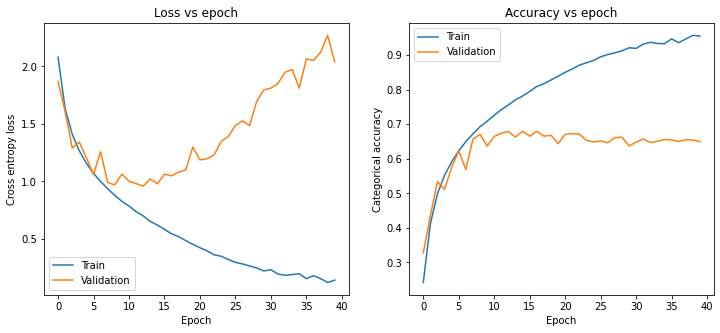

In [218]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training loss starts off rapidly decreasing but seems to start converging and the validation loss also starts off rapidly decreasing but then starts to increase again and massively diverge from the training losses. The training loss is converging to 0.14 while the validation loss is at 2.2 after 40 epochs but is steadily increasing. Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy starts off rapidly increasing and again seems to start converging, similarly the validation accuracy starts off rapidly increasing and seem to converge. The training accuracy is converging to 95% while the validation accuracy is converging to 65%.  Here we have massive overfitting because the MLP network performs much worse on the validation dataset compared to the training dataset and so the MLP network is not generalisable and prone to high variation for a new dataset. The difference now is that we have even less convergence and even more overfitting, but the performance of the MLP network on the training dataset has significantly improved while the performance of the MLP network on the validation dataset has significantly suffered. However, we do see that the training and validation losses are much lower for CNN compared to MLP while the training and validation accuracies are much higher for CNN compared to MLP, which shows that it is the better suited neural network for this classification task.

### Part 1.2.2

I will now run the same CNN model as above, but this time just incorporate an L2 regularisation with a coefficient of 5e-3 in all of my convolutional layers. L2 regularisation ensures that our parameters stay sufficiently small to avoid overfitting, it does this by scaling down the parameters whenever they get too large. This is done in TensorFlow by simply defining L2 regularisation to be the kernel_regularizer (which is default set to None):

In [219]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

l2_coeff = 5e-3

model_CNN_2 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(l2_coeff), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

TensorFlow enables me to obtain a summary of my CNN model so that I can see if the model I created fits the desired architecture, it also shows me the number of parameters and the output shape of each layer, so that I can better understand my defined network

In [220]:
# Print the model summary

model_CNN_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

For this CNN, the required optimisation method is SGD (the same as explained in the MLP section) with a learning rate of 0.1 and the loss function is cross-entropy (again, the same as explained in the MLP section), so I will implement this into my CNN model now:

In [221]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

model_CNN_2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Finally, I have defined my model to fit the required architecture along with SGD optimisation and cross-entropy loss, so now I will use TensorFlow to run it

In [222]:
history_2 = model_CNN_2.fit(train_data, epochs=40, verbose=1, validation_data=val_data)

Epoch 1/40
391/391 [==============================] - 79s 202ms/step - loss: 2.4907 - accuracy: 0.2402 - val_loss: 2.1624 - val_accuracy: 0.3358
Epoch 2/40
391/391 [==============================] - 84s 214ms/step - loss: 1.9846 - accuracy: 0.3830 - val_loss: 2.0706 - val_accuracy: 0.3473
Epoch 3/40
391/391 [==============================] - 64s 164ms/step - loss: 1.7418 - accuracy: 0.4469 - val_loss: 1.6312 - val_accuracy: 0.4808
Epoch 4/40
391/391 [==============================] - 75s 191ms/step - loss: 1.6177 - accuracy: 0.4844 - val_loss: 1.5549 - val_accuracy: 0.5051
Epoch 5/40
391/391 [==============================] - 65s 166ms/step - loss: 1.5309 - accuracy: 0.5179 - val_loss: 1.5561 - val_accuracy: 0.5053
Epoch 6/40
391/391 [==============================] - 84s 215ms/step - loss: 1.4703 - accuracy: 0.5479 - val_loss: 1.4510 - val_accuracy: 0.5487
Epoch 7/40
391/391 [==============================] - 80s 204ms/step - loss: 1.4363 - accuracy: 0.5615 - val_loss: 1.6714 - val_ac

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a learning rate of 0.01, but with an L2 regularisation with a coefficient of 5e-3:

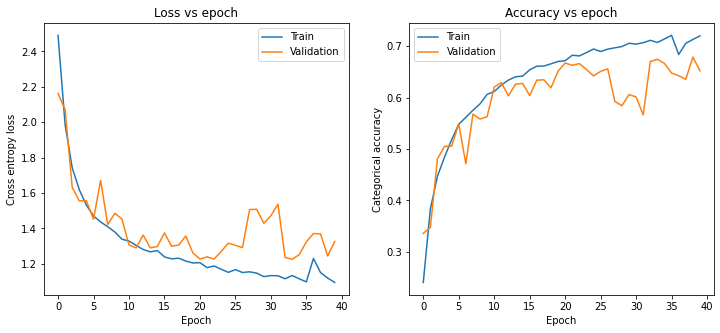

In [227]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_2.history['loss'], label='Train')
plt.plot(history_2.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_2.history['accuracy'], label='Train')
plt.plot(history_2.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training and validation losses behave similarly although the validation loss is slightly higher. They both starts off rapidly decreasing and start to converge. The training loss is converging to 1.1 while the validation loss is converging to 1.3. Now for the accuracies, again the training and validation accuracies behave similarly although the training accuracy is slightly higher. They both starts off rapidly increasing and start to converge. The training accuracy is converging to 72% while the validation loss is converging to 65%.
We see that the L2 regularisation must have worked as it made the parameters small enough to greatly lessen the overfitting, so the CNN is more generalisable and not prone to high variation for a new dataset, as seen because the performs fairly similar on the training and validation datasets. This large reduction in overfitting did however make our accuracies suffer, as they are now lower but not to the point where we would say that the CNN has not performed well. The L2 regularisation seems to create a balance between little overfitting and decent accuracy values.

### Part 1.2.3

I will now run the same CNN model as above, but this time just incorporate an L1 regularisation with a coefficient of 5e-3 in all of my convolutional layers. Similar to L2 regularisation, L1 regularisation ensures that our parameters stay sufficiently small to avoid overfitting, but it is stronger than L2 regularisation because when L1 regularisation is scaling down the parameters, it pushes them closer to zero. This is done in TensorFlow by simply defining L2 regularisation to be the kernel_regularizer (which is default set to None):

In [489]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

l1_coeff = 5e-3

model_CNN_3 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(l1_coeff), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , kernel_regularizer=regularizers.l1(l1_coeff), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , kernel_regularizer=regularizers.l1(l1_coeff), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

TensorFlow enables me to obtain a summary of my CNN model so that I can see if the model I created fits the desired architecture, it also shows me the number of parameters and the output shape of each layer, so that I can better understand my defined network

In [490]:
# Print the model summary

model_CNN_3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)              

For this CNN, the required optimisation method is SGD (the same as explained in the MLP section) with a learning rate of 0.1 and the loss function is cross-entropy (again, the same as explained in the MLP section), so I will implement this into my CNN model now:

In [491]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

model_CNN_3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Finally, I have defined my model to fit the required architecture along with SGD optimisation and cross-entropy loss, so now I will use TensorFlow to run it

In [492]:
history_3 = model_CNN_3.fit(train_data, epochs=40, verbose=1, validation_data=val_data)

Epoch 1/40
391/391 [==============================] - 82s 210ms/step - loss: 3.7526 - accuracy: 0.1834 - val_loss: 2.1700 - val_accuracy: 0.2514
Epoch 2/40
391/391 [==============================] - 81s 206ms/step - loss: 2.1709 - accuracy: 0.2514 - val_loss: 2.0916 - val_accuracy: 0.2917
Epoch 3/40
391/391 [==============================] - 82s 210ms/step - loss: 2.1136 - accuracy: 0.2767 - val_loss: 2.0534 - val_accuracy: 0.3040
Epoch 4/40
391/391 [==============================] - 72s 184ms/step - loss: 2.0811 - accuracy: 0.2891 - val_loss: 2.0247 - val_accuracy: 0.3112
Epoch 5/40
391/391 [==============================] - 71s 183ms/step - loss: 2.0519 - accuracy: 0.3050 - val_loss: 1.9948 - val_accuracy: 0.3184
Epoch 6/40
391/391 [==============================] - 72s 183ms/step - loss: 2.0290 - accuracy: 0.3158 - val_loss: 1.9946 - val_accuracy: 0.3272
Epoch 7/40
391/391 [==============================] - 74s 189ms/step - loss: 2.0125 - accuracy: 0.3230 - val_loss: 1.9881 - val_ac

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a learning rate of 0.01, but with an L1 regularisation with a coefficient of 5e-3:

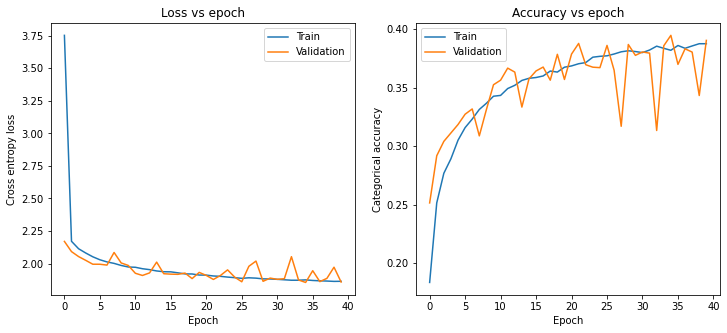

In [493]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_3.history['loss'], label='Train')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_3.history['accuracy'], label='Train')
plt.plot(history_3.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training and validation losses behave similarly although the validation loss fluctuates as L1 regularisation is stronger than L2 regularisation and pushes the parameters close to zero each time, causes larger losses as shown by the spikes. Both the training and validation losses start off rapidly decreasing and both very quickly start to converge to 1.85. Now for the accuracies, again the training and validation accuracies behave similarly although the large spikes in the validation accuracies are due to the aggressive rescaling of L1 regularisation, causing the large inaccuracies. Both the training and validation inaccuracies start off rapidly rapidly increasing and both very quickly start to converge to 39%. We see that the L1 regularisation must have worked as it made the parameters small enough to completely eradicate the overfitting, so the CNN is fully generalisable and not prone to variation for a new dataset, as seen because the performs the same on the training and validation datasets. However, since L1 regularisation almost pushes the parameters to zero, it is better than L2 regularisation at reducing overfitting but comes at the huge cost of very low accuracies. Unlike the L2 regularisation, L1 regularisation is not balanced and is much more focused on reducing overfitting in turn sacrificing the accuracy values, so L2 regularisation seems superior to L1 regularisation in general but it depends on what is desired. 

I will now run the same CNN model as above, but this time just incorporate a Dropout, with a rate of 0.5 and no regularisation method. Similar to kernal regularisation methods, Dropout keeps the parameters small by dropping out some outputs between the dense layers and then rescaling the parameters to ensure they are kept small. This is done in TensorFlow by simply adding Dropout(0.5) between my Dense layers:

In [238]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model_CNN_4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3) , activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

TensorFlow enables me to obtain a summary of my CNN model so that I can see if the model I created fits the desired architecture, it also shows me the number of parameters and the output shape of each layer, so that I can better understand my defined network

In [239]:
# Print the model summary

model_CNN_4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

For this CNN, the required optimisation method is SGD (the same as explained in the MLP section) with a learning rate of 0.1 and the loss function is cross-entropy (again, the same as explained in the MLP section), so I will implement this into my CNN model now:

In [240]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

model_CNN_4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Finally, I have defined my model to fit the required architecture along with SGD optimisation and cross-entropy loss, so now I will use TensorFlow to run it

In [241]:
history_4 = model_CNN_4.fit(train_data, epochs=40, verbose=1, validation_data=val_data)

Epoch 1/40
391/391 [==============================] - 65s 167ms/step - loss: 2.1254 - accuracy: 0.2172 - val_loss: 1.9333 - val_accuracy: 0.2967
Epoch 2/40
391/391 [==============================] - 64s 165ms/step - loss: 1.7715 - accuracy: 0.3589 - val_loss: 1.6187 - val_accuracy: 0.4037
Epoch 3/40
391/391 [==============================] - 65s 165ms/step - loss: 1.5828 - accuracy: 0.4314 - val_loss: 1.4374 - val_accuracy: 0.4847
Epoch 4/40
391/391 [==============================] - 65s 167ms/step - loss: 1.4653 - accuracy: 0.4771 - val_loss: 1.3234 - val_accuracy: 0.5226
Epoch 5/40
391/391 [==============================] - 64s 164ms/step - loss: 1.3697 - accuracy: 0.5153 - val_loss: 1.2393 - val_accuracy: 0.5576
Epoch 6/40
391/391 [==============================] - 66s 169ms/step - loss: 1.2932 - accuracy: 0.5414 - val_loss: 1.1944 - val_accuracy: 0.5802
Epoch 7/40
391/391 [==============================] - 65s 165ms/step - loss: 1.2280 - accuracy: 0.5668 - val_loss: 1.1545 - val_ac

I will now plot these training and validation losses and accuracies against the number of epochs to see how well our MLP model is learning for 40 epochs and a learning rate of 0.01, but with a dropout rate of 0.5 and no regularisation method:

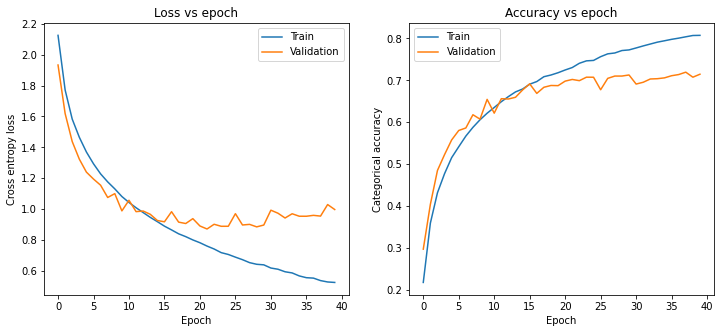

In [242]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_4.history['loss'], label='Train')
plt.plot(history_4.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_4.history['accuracy'], label='Train')
plt.plot(history_4.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

I will start with the losses, from the plot above on the left it is clear to see that the training loss starts off rapidly decreasing and seems to slowly start to converge while the validation loss also starts off decreasing very quickly but also seems to converge quickly. The training loss is converging to 0.5 and the validation loss is converging to 1. Now for the accuracies, from the plot above on the right it is clear to see that the training accuracy starts off rapidly increasing and seems to slowly start to converge while the validation accuracy also starts off increasing very quickly and but also seems to converge quickly. The training accuracy is converging to 80% and the validation accuracy is converging to 71%. Here we have overfitting because the CNN network performs worse on the validation dataset compared to the training dataset and so the MLP network is not generalisable and prone to high variation for a new dataset. We see that Dropout must have worked as it made the parameters small enough to lessen the overfitting, so the CNN is now more generalisable and not prone to very high variation for a new dataset but there is still some overfitting, as seen because the performs slightly better on the training dataset than the validation dataset. However, with Dropout we have much better accuracy values, but there is still an element of overfitting here, so we observe that Dropout is not as good as L2 regularisation at reducing the amount of overfitting but as a result of this, Droput is able to maintain better accuracy values, although not by much, so L2 regularisation seems superior to Dropout in general but it depends on what is desired. 

### Part 1.2.4

In regards to computational time, the CNN with Dropout ran quite a lot slower than the MLP network in 1.1.1, this is because the CNN having ~122,000 trainable parameters compared to the ~1,800,000 for the MLP network, CNN has roughly a lot more computations to run and as a result, it takes significantly longer to run. The computation for my 1.1.1 MLP network was roughly ~15 minutes in total, compared to about ~45 minutes for the CNN with Droput with both running over 40 epochs, this is ~3x longer and is all down to how many more computations CNN has to run despite having ~15x less trainable parameters. In terms of overfitting, the 1.1.1 MLP network and CNN perform fairly similarly, both run better on the training datasets, obtaining higher accuracies and lower losses compared to the validation dataset, however the difference in performance between these two datasets is not major, so the overfitting problem is not huge. The main difference comes in the performance, the accuracies for CNN are significantly higher than the 1.1.1 MLP network and the losses for CNN are significantly lower than the 1.1.1 MLP network so we see that CNN sacrifices computational time for performance, as CNN takes ~3x longer but performs far better than the 1.1.1 MLP network on both the training and validation datasets, so the superior network depends on which is more valued, computational time or accuracy, of these I'd choose accuracy and say CNN performs better and warrants the longer computational time.

# Task 2: Unsupervised Learning

In unsupervised learning, a model is provided with an unlabeled dataset and it must learn patterns/groupings within this dataset. The model is not told what it must learn, so it is just left to draw conclusions from the unlabeled data, with minimal human supervision. 

I will be working with the Zachary's karate club dataset, which will provide us with:
* Feature matrix F - 34x100 matrix characterising the personalities of the individuals in the karate club
* Adjacency matrix A - 34x34 matrix containing the information about the friendships between the individuals

In order to be able to use this data, I need to preprocess it before I can input it into the unsupervised learning algorithms that I will use in this section. The preprocessing steps are as follow:

1. Subtract the mean $\mu$ from each data point
2. Scale each data point by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation

These preprocessing steps ensure that the data will have the mean as 0 and the variance as 1. These preprocessing
steps are also known as [Data Normalization or Feature Scaling] - see references at the bottom.

I will now use csv.reader to import the feature matrix F from a microsoft excel spreadsheet, and just quickly check that I have imported the correct dataset.

In [19]:
# Import our feature matrix F from excel
import csv

feature_matrix = csv.reader(open("feature_matrix_karate_club1.csv", "r"), delimiter=",")
feature_matrix = list(feature_matrix)
F = np.array(feature_matrix).astype("float")
print(F.shape)
print(F)

(34, 100)
[[ 0.14864008 -0.18710981 -0.10939524 ...  0.02139415 -0.0219182
   0.09143373]
 [ 0.20700055 -0.01897949 -0.09448294 ... -0.03428907 -0.14576454
  -0.02500351]
 [ 0.09396198 -0.26245123 -0.03301012 ... -0.08545066 -0.02417422
   0.16861194]
 ...
 [ 0.07163295  0.02107777 -0.0286725  ...  0.07991265 -0.13502657
  -0.03348165]
 [ 0.16400485 -0.13058038 -0.13862133 ...  0.00711885  0.09925542
   0.15335855]
 [-0.00401106 -0.10642391 -0.10301867 ...  0.049763   -0.14943294
   0.01960115]]


I will now define a function that will preprocess my data in the way described above:

In [20]:
# Define a function to allow us to preprocess data
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

I will now preprocess the feature matrix F so it is ready for use:

In [21]:
F = normalize(F)

## 2.1 Clustering of the Feature Matrix (CFM)

Clustering is a data mining technique in the unlabeled data is grouped into clusters based on their similarities. In clustering algorithms, a raw, unlabeled dataset is processed into groups called clusters, where the data points in each clusters will share some similarity in structure/pattern.

### Part 2.1.1

I will use k-means clustering to cluster the feature matrix F, which is a type of exclusive/hard clustering. This type of clustering means that each data point can exist only in one cluster.  K-means clustering works by assigning data points into K clusters, based on each data point's distance from each clusters’s centroid, i.e. the data points closest to a given centroid will be clustered under the same category, and there will be K clusters in total. The nature of this method means that for larger values of K, we will get smaller, tighter groupings whereas a smaller K value will have larger, more spread groupings.
I will now implement the following k-means clustering algorithm which is described in the lecture notes under the "k-means algorithm for clustering" heading:

In [133]:
def k_means_clustering(k):
    
    # Calculate the shape of the feature matrix
    samples, features = F.shape
    # Define a number of maximum iterations that we cannot excede to make sure our algorithm always terminates at some point
    max_iterations = 15
    # Preallocate our new labels 
    new_labels = np.zeros(len(F))
    n_k = np.zeros(k)
    # Set the number of random initialisations, here I will choose 100 as required
    rand_initialisations = 100
    # Preallocate where we will store the within-cluster distances 
    Big_WCD = np.zeros(rand_initialisations)
    
    for i in range(rand_initialisations):
        #
        np.random.seed(4*i)
        #Assign a l
        labels = np.random.randint(low = 0, high = k, size = samples)
        # We want to ensure every label is used at least once
        ensure_once = np.random.choice(samples, k, replace = False)
        for j in range(k):
            # Avoid empty clusters
            labels[ensure_once[j]] = j
        F_labels = np.append(F, labels.reshape(-1, 1), axis = 1)
        
        # Computing the centroids of each of the k clusters
        centroids = np.zeros((k, features))
        for l in range(k):
            centroids[l] = np.mean([x for x in F_labels if x[-1] == l], axis = 0)[0:features]
        
        for m in range(max_iterations):
            # Find the distance between the data points and the centroids
            dist = np.array([np.linalg.norm(F -cent, axis = 1) for cent in centroids])
            new_labels = np.argmin(dist, axis = 0)
            
            if (labels == new_labels).all():
                labels = new_labels
                # Calculate the within-cluster distance
                WC_dist = np.sum(np.ndarray.min(np.square(dist), axis = 0))
                # Store these within distance values
                Big_WCD[i] = WC_dist
                break
            else:
                labels = new_labels
                for n in range(k):
                    # Update centroids by taking the mean over the associated data points
                    if (labels == n).any():
                        centroids[n] = np.mean(F[labels == n], axis = 0)
    
    return Big_WCD, labels

I will test my k-means clustering function for k = 4, and we see that we obtain 100 within-cluster distances so I am happy with how it is working and I will proceed. The 'labels' output of my k-means clustering function will be used later in another section.

In [46]:
print(k_means_clustering(4)[0].shape)
print(k_means_clustering(4)[0])

(100,)
[1636.18690652 1661.22343145 2069.8893885  1654.52342197 2193.10355897
 1636.18690652 1702.2991389  1670.42597083 1662.36986248 1702.2991389
 1654.52342197 1661.22343145 1641.8048244  1818.7435783  1661.22343145
 1836.54206308 2238.89692826 1654.52342197 1648.0550109  1816.85985413
 1718.00740344 2001.68219187 1619.08647998 1636.18690652 1827.6402051
 1695.47368669 1785.87421446 1951.49036113 1676.91526937 1844.04385588
 1852.02571594 1708.12863851 1792.78719211 1702.2991389  1619.08647998
 1963.78174205 1712.09867135 1711.92699309 1835.30492974 1635.57359455
 1670.42597083 1670.42597083 1855.66167215 1636.18690652 1778.54562081
 1654.52342197 1654.52342197 1636.18690652 1636.18690652 1636.18690652
 2157.86316934 1808.87581868 1802.10497384 2021.23725679 1636.18690652
 1623.51449603 1661.22343145 1654.52342197 1842.92893325 1789.29007034
 1641.8048244  1815.5197968  1797.28349174 1691.63862259 1623.51449603
 1654.52342197 1635.57359455 1635.57359455 1826.70448551 1834.10302307
 

I will now quickly define a function that uses my k-means clustering function and just outputs the mean of all the 100 within-cluster distances so that I am able to plot the average within-cluster distance against the value of k later on

In [24]:
# Create a k_means_clustering function that only outputs the mean of all the 100 within-cluster distances

def KMC_getW(k):
    
    # Take the Big_WCD output from the k_means_clustering function
    Big_WCD = k_means_clustering(k)[0]
    # Calculate the mean within-cluster distance
    WC_dist_mean = np.mean(Big_WCD)
    return WC_dist_mean

# Vectorize the KMC_getW function to allow us to input vectors into the function so we obtain points to plot
KMC_getW_vec = np.vectorize(KMC_getW, cache = True)

I will test for this 'KMC_getW()' function for k = 4, and we see that we obtain the mean of the 100 within-cluster distances obtained from my k-means clustering function

In [25]:
KMC_getW(4)

1748.4967931013878

Now I am able to use this function to plot the value of k against the mean within-cluster distance for the values of k between 2 and 10 as required:

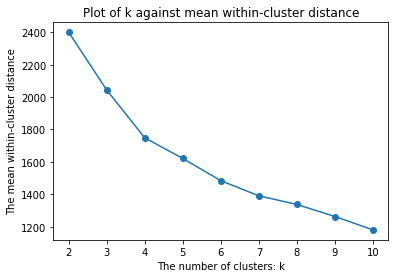

In [50]:
# Create the k values between 2 and 10 to plot 
k_values = np.arange(2, 11)
W_values = KMC_getW_vec(k_values);
plt.plot(k_values, W_values, '-o');
plt.xlabel('The number of clusters: k');
plt.ylabel('The mean within-cluster distance');
plt.title('Plot of k against mean within-cluster distance');

From the plot it is clear that our within-cluster distance is getting smaller as k (the number of clusters) increases, this was predicted in my introduction of the k-means clustering algorithm, as I said "the nature of this method means that for larger values of k, we will get smaller, tighter groupings" which can be directly interpreted as 'for higher k, our within-cluster distance will be smaller'. From the plot, I will argue that 'k = 4' is the optimal clustering according to the mean within-cluster distances for this dataset by 'The Elbow Method' [Elbow method (clustering)] - see references at the bottom. This method states that the point of the kink, i.e. where the decrease in the within-cluster distance decreases or where the gradient flattens is the optimal clustering as beyond this point, the decrease in the within-cluster distance per increment of k is not as high as before the kink. Clearly at 'k = 34' we will have a within-cluster distance of zero but this clustering is not useful as it means we have not grouped any of the data points, hence the optimal clustering is taken to be at the kink/elbow, which for me is at k = 4.

### Part 2.1.2

I will now define the Calinski-Harabasz (CH) score, which I will use instead of within-cluster distances to determine the value of k which gives the optimal clustering. I researched the CH score and will use the formula/definition that I found on [Calinski-Harabasz Index – Cluster Validity indices] - see references at the bottom, which is as follows:
$$
CH_{k} = \frac{\sum_{i=1}^{k} n_{i}||c_{i} - c||^{2}}{\sum_{i=1}^{k}\sum_{j=1}^{n_{k}} ||x_{j} - c_{i}||^{2}} \frac{N - k}{k - 1} 
$$
$$
$$
where $\sum_{i=1}^{k} n_{i}||c_{i} - c||^{2}$ is the between-cluster distance, which I will denote as $B_{k}$, $\sum_{i=1}^{k}\sum_{j=1}^{n_{k}} ||d_{j} - c_{i}||^{2}$ is the within-cluster distance, which I will denote as $W_{k}$, k is the number of clusters, N is the total number of samples, c is the global centroid, $x_{j}$ are the data points, $n_{k}$ is the number of data points in the $k^{th}$ cluster and $c_{k}$ is the centroid of the $k^{th}$ cluster.
$$
$$
Using this, I can simply present the CH score as the following formula:
$$
CH_{k} = \frac{B_{k}}{W_{k}} \frac{N - k}{k - 1} 
$$
$$
$$
The CH score is a ratio of $B_{k}$ and $W_{k}$, which are the between-cluster and within-cluster distances respectively. $B_{k}$ measures how far apart the clusters are and $W_{k}$ measurs how dense the clusters are. We can understand from this that a higher CH score represents a more ideal clustering as the clusters are dense and well-spread.

I will now define a CH score function that implements the formula above and will allow me to obtain the CH scores for different values of k. 

In [51]:
# The following function implements what was explained above to find the Calinski-Harabasz (CH) score
def Cal_Hara(k):
    
    # Calculate the number of samples in the dataset
    samples = F.shape[0]
    # Obtain the 100 within-cluster distances from the k-means clustering algorithm
    Big_WCD = k_means_clustering(k)[0]
    # Calculate the global centroid
    global_centroid = np.mean(F, axis = 0)
    # Calculate the 100 corresponding between-cluster distances
    Bk_sum = np.sum(np.square(F - global_centroid))
    Big_BCD = Bk_sum - Big_WCD
    # Calculate the CH score
    CH_Score = np.divide(Big_BCD, Big_WCD) * ((samples - k) / (k - 1))
    return CH_Score, Big_WCD, Big_BCD

I will test my CH score function for k = 4, and we see that we obtain 100 CH scores so I am happy with how it is working and I will proceed. The 'Big_WCD' and 'Big_BCD' are stores of the 100 within- and between-cluster distances respectively and will be used later in another section.

In [52]:
print(Cal_Hara(4)[0].shape)
print(Cal_Hara(4)[0])

(100,)
[10.78002205 10.46684351  6.4259985  10.5497242   5.50314387 10.78002205
  9.97298784 10.35408967 10.45272882  9.97298784 10.5497242  10.46684351
 10.7089171   8.69422408 10.46684351  8.5130527   5.18604969 10.5497242
 10.63037931  8.71360629  9.79036873  6.98571339 10.99949596 10.78002205
  8.60322393 10.05339291  9.03829493  7.42258157 10.27532376  8.43773937
  8.3582764   9.90482405  8.96488337  9.97298784 10.99949596  7.313533
  9.85866853  9.86066003  8.52553189 10.7878142  10.35408967 10.35408967
  8.32230547 10.78002205  9.11674325 10.5497242  10.5497242  10.78002205
 10.78002205 10.78002205  5.75632806  8.79620461  8.86682546  6.82138002
 10.78002205 10.94222139 10.46684351 10.5497242   8.44889371  9.00194975
 10.7089171   8.72741903  8.91743854 10.09885536 10.94222139 10.5497242
 10.7878142  10.7878142   8.61275333  8.53767186  8.99894652 10.5497242
 10.5497242  10.94222139 10.78002205 10.7089171   8.57616925  7.11184734
  6.95794035 10.99949596  8.85977196  9.97298784 

I will now quickly define a function that uses my CH score function and just outputs the mean of all the 100 CH scores so that I am able to plot the mean CH score against the value of k later on

In [53]:
def CH_getCH(k):
    
    CH_Score_mean = np.mean(Cal_Hara(k)[0])
    return CH_Score_mean

# Vectorize the CH_getW function to allow us to input vectors into the function so we obtain points to plot
CH_getCH_vec = np.vectorize(CH_getCH, cache = True)

I will test for this 'CH_getCH()' function for k = 4, and we see that we obtain the mean of the 100 CH scores obtained from my CH score function

In [54]:
CH_getCH(4)

9.55530715590577

Now I am able to use these function to plot the value of k against the mean CH score for the values of k between 2 and 10 as required:

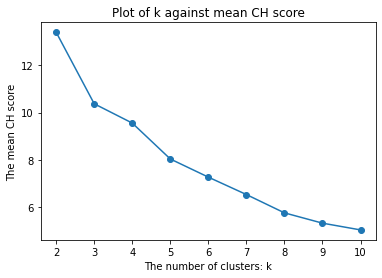

In [134]:
#Create the k values between 2 and 10 to plot 
k_values = np.arange(2, 11)
CH_values = CH_getCH_vec(k_values)
plt.plot(k_values, CH_values, '-o');
plt.xlabel('The number of clusters: k');
plt.ylabel('The mean CH score');
plt.title('Plot of k against mean CH score');

From the plot it is clear that our CH scores are falling as k (the number of clusters) increases. From the plot, I will argue that 'k = 2' is the optimal clustering for this dataset according to the CH scores because 'k = 2' gives the highest CH score. I know from my explanation above that the CH score is "a ratio of $B_{k}$ and $W_{k}$, which are the between-cluster and within-cluster distances respectively. $B_{k}$ measures how far apart the clusters are and $W_{k}$ measurs how dense the clusters are". Ideally, we want a high value for $B_{k}$ as we want our clusters to be far apart and a low value for $W_{k}$ as we want our clusters to be tightly packed, as a result we want $\frac{B_{k}}{W_{k}}$ to be as high as possible so as a result, 'k = 2' is the optimal clustering since it gives the highest CH score.

### Part 2.1.3

The robustness is a measure of well-spread and dense the clusters are, so the CH score is a very strong indicator of robustness. So by the CH score, we know that the optimal clusterings is 'k = 2' but from k-means with the 100 random initialisations we have that the optimal clusterings is 'k = 4', which have a fairly low CH score, especially compared to 'k = 2'. So, the CH score shows that the k-means clustering algorithm is not the best at outputing optimal clusterings when looking for robustness, as the clusters are not as well-spread and dense as they could be if we used another algorithm. I will now question the variability of the CH score to see if it has much variance so that I can understand if it really is a good indicator of robustness.

I will define a function similar to one before but this time I will obtain the variance of the CH scores rather than the means:

In [124]:
def CH_getCH_var(k):
    
    CH_Score_var = np.var(Cal_Hara(k)[0])
    return CH_Score_var

# Vectorize the CH_getW function to allow us to input vectors into the function so we obtain points to plot
CH_getCH_var_vec = np.vectorize(CH_getCH_var, cache = True)

Now I am able to use this function to plot the value of k against the variance of the CH score for the values of k between 2 and 10 for which I want to check the variability of the CH score to understand how it performs as a measure of robustness:

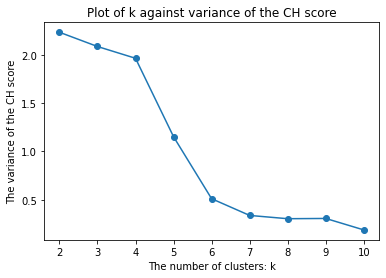

In [127]:
#Create the k values between 1 and 10 to plot 
k_values = np.arange(2, 11)
CH_values = CH_getCH_var_vec(k_values)
plt.plot(k_values, CH_values, '-o');
plt.xlabel('The number of clusters: k');
plt.ylabel('The variance of the CH score');
plt.title('Plot of k against variance of the CH score');

From the plot above, I see that the variance falls as k increases which is expected, but I would say that in the range that we are looking at which is: k = 2, 3, 4 the variance is quite low for the CH score and so this leads me to believe that the performance of the CH score is not dependant on the initialisations and so it is a good measure of robustness. As a result, I believe that the CH score is a strong measure of robustness and that if we want to find optimal clusterings that allow for good robustness of the clusterings, we should follow the optimal k given by the CH score rather than the k-means algorithm.

## 2.2 Dimensionality Reduction of the Feature Matrix (DRFM)

Dimensionality reduction is the transformation of data from a high-dimensional space into a lower-dimensional space so that the low-dimensional representation retains meaningful information of the original data. This allows us to retain a significant proportion of information while compressing the data. The main benefits of this include:
* The storage space required for the data is significantly reduced by eliminating redundant features, reducing computation time
* The noise in the data is reduced and the model’s accuracy and performance is improved.

I will carry out dimensionality reduction using principle component analysis (PCA). From the lectures notes, I know that to perform PCA on some dataset $\boldsymbol X$, I need to follow these steps: 

1. Compute the covariance matrix:    $\mathbf C = \frac{1}{(n - 1)}\mathbf X^\top \mathbf X$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix:   $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the space spanned by the top $n$ eigenvectors.

### Part 2.2.1

Firstly, I will implement a PCA function that carries out the steps described above:

In [55]:
# Import the required modules
from scipy.sparse import linalg

# My PCA function takes in the dataset X and k, which defines the k-dimensional space that I will span the samples over
def pca_function(X, k):

    # Create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # Compute eigenvalues and eigenvectors of C using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:, sorted_index]

    # Transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

I will now use my PCA function to obtain the dataset as points in the d-dimensional PCA space and then use this to create a plot. I will do this for the following dimensions: 
* d = 1
* d = 2
* d = 3

In [63]:
# Define our dimensions
k1 = 1
k2 = 2
k3 = 3

# Compute the projection, the eigenvectors and eigenvalues from our PCA function in each dimension
X_pca1, eigenvectors1, eigenvalues1 = pca_function(F, k1) 
X_pca2, eigenvectors2, eigenvalues2 = pca_function(F, k2) 
X_pca3, eigenvectors3, eigenvalues3 = pca_function(F, k3) 

I will firstly plot the samples of the dataset as points in the 1-dimensional PCA space:

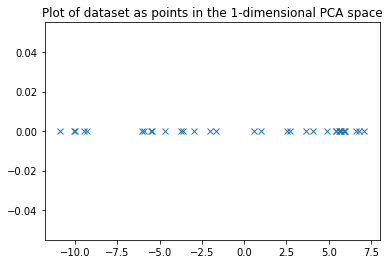

In [64]:
# Plot the 1-dimensional case

plt.plot(X_pca1[:,0], np.zeros_like(X_pca1[:,0]), 'x');
plt.title('Plot of dataset as points in the 1-dimensional PCA space');

From this 1-dimensional PCA space plot, I see that there are 3 or 4 clusters, depending on how dense the clusters are defined to be. If we take it as 4 clusters, this agrees with the optimal cluster 'k = 4' from the k-means clustering algorithm from 2.1 but we can also look at it in the way that if we understand that there are 3 clusters on this plot, then there might be some significance in this because we obtain 'k = 3' which is inbetween the optimal 'k = 2' from the CH score and 'k = 4' from the k-means algorithm, both from 2.1. However, if we define the clusters to be very dense/tight we can have even have up to 5 or 6 clusters, which does not relate to the optimal clusterings from 2.1.

I will now plot the samples of the dataset as points in the 2-dimensional PCA space:

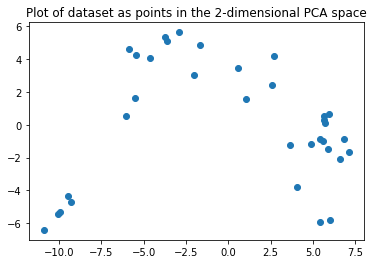

In [65]:
# Plot the 2-dimensional case

plt.scatter(X_pca2[:, 0], X_pca2[:, 1]);
plt.title('Plot of dataset as points in the 2-dimensional PCA space');

Similar to the 1-dimensional case, in this 2-dimensional PCA space plot I see that there are 3 or 4 clusters, again depending on how dense the clusters are defined to be. If we take it as 4 clusters, as before this agrees with the optimal cluster 'k = 4' from the k-means clustering algorithm from 2.1 but we can also look at it in the way that if we understand that there are 3 clusters on this plot, then there might be the same significance in this because we obtain 'k = 3' which is inbetween the optimal 'k = 2' from the CH score and 'k = 4' from the k-means algorithm, both from 2.1. Again just like the 1-dimensional case, if we define the clusters to be very dense/tight we can have even have up to 5 or 6 clusters, which does not relate to the optimal clusterings from 2.1.

Finally, I will firstly plot the samples of the dataset as points in the 3-dimensional PCA space:

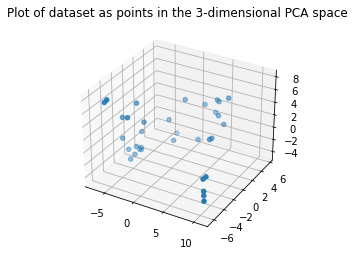

In [66]:
# Plot the 3-dimensional case

fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2]);
plt.title('Plot of dataset as points in the 3-dimensional PCA space');

Similar to the 1-dimensional and 2-dimensional cases, in this 3-dimensional PCA space plot I see that there are 3 or 4 clusters, depending on how dense the clusters are defined to be. If we take it as 4 clusters, again this agrees with the optimal cluster 'k = 4' from the k-means clustering algorithm from 2.1 but we can also look at it in the way that if we understand that there are 3 clusters on this plot, again then there might be some significance in this because we obtain 'k = 3' which is inbetween the optimal 'k = 2' from the CH score and 'k = 4' from the k-means algorithm, both from 2.1. Similar to the 1-dimensional and 2-dimensional cases, if we define the clusters to be very dense/tight we can have a lot more clusters, but here it seems justifiable to go even higher, up to even have up to 7, 8 or even 9 clusters, but this again does not relate to the optimal clusterings from 2.1.

### Part 2.2.2

Now I will consider the explained variance of these PCA approximations of reduced dimensionality, where explained variance is simply:
$$
\textit{explained variance} = \frac{\textit{eigenvalue}}{\textit{total variance}}
$$
$$
$$
where the total variance is the sum of the absolute value of all of the eigenvalues of the covariance matrix:  $\mathbf C$

I will now compute and plot the explained variance of the PCA approximations of reduced dimensionality for values of d in the interval [1, 10]:

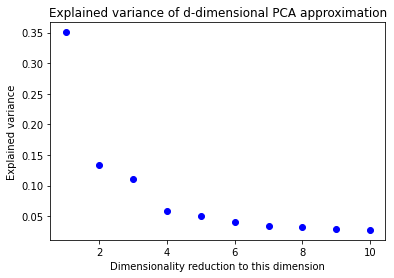

In [69]:
# Create a loop to find the explained variance for d = 1, 2, ..., 10
for d in range(1, 11):
    
    # Use my PCA function to find the projection as well as the eigenvalues and eigenvectors of the feature matrix F
    X_pca, eigenvectors, eigenvalues = pca_function(F, d)
    # Compute the covariance matrix C
    C = 1.0/(len(F)-1) * np.dot(F.T, F)
    # Find the eigenvalues of C
    all_eigenvalues, _ = np.linalg.eig(C)
    # Use these eigenvales to find the total variance
    total_variance = abs(all_eigenvalues.sum())
    # Find the explained variance of the d-dimensional PCA approximation
    explained_variances = eigenvalues /  total_variance
    plt.scatter(d, explained_variances[-1], color='b')

plt.xlabel('Dimensionality reduction to this dimension');
plt.ylabel('Explained variance');
plt.title('Explained variance of d-dimensional PCA approximation');
plt.show();

From the lecture notes, I know that the ideal dimensionality is the one before the large drop off in explained variance, so from the plot it can be argued that the ideal dimension is d = 1 or d = 3. To build on this, I considered the spectral decomposition of $M$ = $F^{T}F$ so I will find the eigenvalues of matrix M using the following code:

c:\users\winuser\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


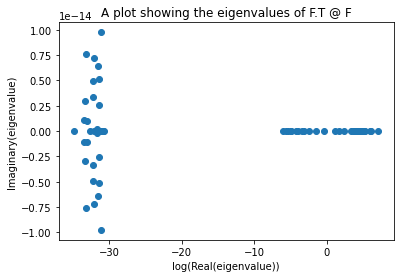

In [72]:
# Obtain the eigenvalues and eigenvectors of M using linalg.eig from before
eigenvalues, eigenvectors = np.linalg.eig(F.T @ F)
# Split the real and imaginary parts of each eigenvalue
x = [eig.real for eig in eigenvalues]
y = [eig.imag for eig in eigenvalues]
# Plot the eigenvalues of an Argand (Re, Im) diagram
plt.scatter(np.log(x), y)
plt.xlabel('log(Real(eigenvalue))');
plt.ylabel('Imaginary(eigenvalue)');
plt.title('A plot showing the eigenvalues of F.T @ F');
plt.show();

From this we can see that there is a huge jump in the eigenvalues for some dimension d, and so the following logarithmic plot will allow me to identify for which value this is:

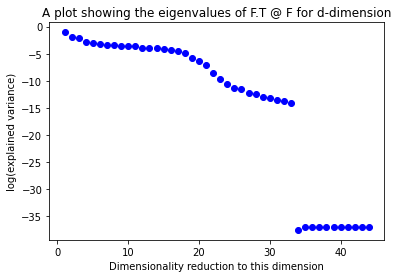

In [74]:
# Create a loop over 45 dimensions to see for which eigenvalue there is a huge jump
for k in range(1, 45):
    # Calculate the explained variance for each dimension as before
    X_pca, eigenvectors, eigenvalues = pca_function(F, k)
    C = 1.0/(len(F)-1) * np.dot(F.T, F)
    all_eigenvalues, _ = np.linalg.eig(C)
    total_variance = abs(all_eigenvalues.sum())
    explained_variances = eigenvalues /  total_variance
    # This time plot on a logarithmic scale since we are deal with a very small scale. Add 1e-16 to avoid an input of 
    # zero into the log function.
    plt.scatter(k, np.log(explained_variances[-1]  + 1e-16), color='b')
plt.xlabel('Dimensionality reduction to this dimension')
plt.ylabel('log(explained variance)')
plt.title('A plot showing the eigenvalues of F.T @ F for d-dimension')
plt.show();

From this we see that the ideal dimension would be d = 33. So now we have three ideal dimensions 'd = 1', 'd = 3' and 'd = 33' and ultimately the ideal dimension has to be a balance of significant reduction in dimension (to allow for faster and easier computation) while still maintaining a large proportion of the dataset information to ensure that it is still recognisable. The loss in data from the dimension reduction can be calculated by the sum of the explained variance of the discarded eigenvalues, so from this we see that for 'd = 1' we retain 35% of the information and have reduced the dimension of the matrix from 34x100 to 34x1, then for 'd = 3' we retain 60% of the information and have reduced the dimension of the matrix from 34x100 to 34x3 and finally for 'd = 33' we retain ~100% of the information and have reduced the dimension of the matrix from 34x100 to 34x33. I believe that the ideal dimension is 'd = 3' as it provides a balance between a massive reduction in dimension but allows us to retain 60% even after discarding 97 features. This feature matrix is well-described because as shown above I am able reduce dimension (by removing columns) and still able to maintain a large proportion of data information.

## 2.3 Graph-Based Analysis (GBA)

Graph-based analysis (GBA) refers to the process of analyzing data in a graph format using data points as nodes and relationships as edges, this is often used when looking at social networks such as Zachary's karate club. GBA is conducted by implementing theoretical algorithms, often using the NetworkX package as it allows for easy visualisation.

### Part 2.3.1

I will now consider node centrality, which allows me to identify nodes that are central within our graph, this is done by . There are a range of methods for identifying node centrality, which measure different structural properties of the network and I will consider three main types: 
* Degree centrality
* Eigenvector centrality
* PageRank centrality

Firstly, I will now use csv.reader to import the adjacency matrix A from a microsoft excel spreadsheet, and just quickly check that I have imported the correct dataset.

In [87]:
# Import our adjacency matrix A from excel
import csv

adjacency_matrix = csv.reader(open("karate_club_graph1.csv", "r"), delimiter=",")
adjacency_matrix = list(adjacency_matrix)
A = np.array(adjacency_matrix).astype("float")
print(A.shape)
print(A)

(34, 34)
[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


Firstly, I will start by defining degree centrality as it was defined in the lecture notes:
$$
\textit{degree centrality} = \frac{\textit{degree}}{N - 1}
$$
$$
$$
Now I will calculate and print this for Zachary's karate club graph:

[0.48484848 0.27272727 0.3030303  0.18181818 0.09090909 0.12121212
 0.12121212 0.12121212 0.15151515 0.06060606 0.09090909 0.03030303
 0.06060606 0.15151515 0.06060606 0.06060606 0.06060606 0.06060606
 0.06060606 0.09090909 0.06060606 0.06060606 0.06060606 0.15151515
 0.09090909 0.09090909 0.06060606 0.12121212 0.09090909 0.12121212
 0.12121212 0.18181818 0.36363636 0.51515152]


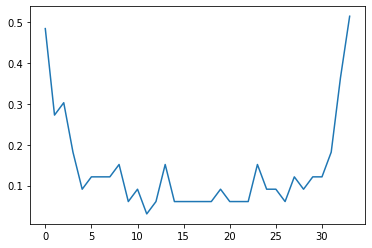

In [88]:
# Compute the degree of the adjacency, which is the size of our NxN matrix A
N = 34

# Calculate the degree centrality as described above
degree = A.sum(axis=1)
degree_centrality = degree / (N - 1)

print(degree_centrality)
plt.plot(degree_centrality);

From this plot I can see that for degree centrality the first, second and last nodes are highly central as they have high centrality values compared to the rest of the nodes.

Next, I will define eigenvector centrality as it was defined in the lecture notes:
$$
\textit{eigenvector centrality} = |v_{max}|
$$
$$
$$
where $v_{max}$ is the eigenvector corresponding to the largest eigenvalue: $\lambda_{max}$.

Now I will calculate and print this for Zachary's karate club graph:

[[0.35549144]
 [0.26595992]
 [0.3171925 ]
 [0.21117972]
 [0.07596882]
 [0.07948305]
 [0.07948305]
 [0.17095975]
 [0.22740391]
 [0.10267425]
 [0.07596882]
 [0.0528557 ]
 [0.08425463]
 [0.22647272]
 [0.10140326]
 [0.10140326]
 [0.02363563]
 [0.09239954]
 [0.10140326]
 [0.14791251]
 [0.10140326]
 [0.09239954]
 [0.10140326]
 [0.15011857]
 [0.05705244]
 [0.05920647]
 [0.07557941]
 [0.13347715]
 [0.13107782]
 [0.13496082]
 [0.1747583 ]
 [0.19103384]
 [0.30864422]
 [0.37336347]]


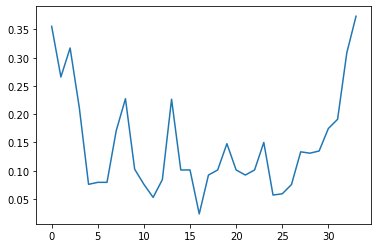

In [89]:
from scipy.sparse import linalg

# Calculate the eigenvector centrality as described above
eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
eigenvector_centrality = np.abs(eigenvector)
print(eigenvector_centrality)
plt.plot(eigenvector_centrality);

From this plot I can see that for eigenvector centrality the first, second, third, fourth as well as the last, second last and third last nodes are highly central as they have high centrality values compared to the rest of the nodes. This shows that a lot more nodes are highly central for eigenvector centrality compared to degree centrality and pagerank centrality (to follow, as pagerank and degree centrality are very similar).

Lastly, I will start by defining degree centrality as it was defined in the lecture notes:
$$
\textit{pagerank centrality} = (I - \alpha(AD^{-1})) c_{PR} = \frac{1}{N}(\mathbf 1 - \mathbf \alpha)
$$
where $A$ is the adjacency matrix, $D$ is the main diagonal of the adjacency matrix, $I$ is the identity matrix, $c_{PR}$ is the pagerank centrality and $\alpha$ is a constant.

Now I will calculate and print this for Zachary's karate club graph:

[[0.09699729]
 [0.05287692]
 [0.05707851]
 [0.03585986]
 [0.02197795]
 [0.02911115]
 [0.02911115]
 [0.0244905 ]
 [0.02976606]
 [0.0143094 ]
 [0.02197795]
 [0.00956475]
 [0.01464489]
 [0.02953646]
 [0.01453599]
 [0.01453599]
 [0.01678401]
 [0.01455868]
 [0.01453599]
 [0.01960464]
 [0.01453599]
 [0.01455868]
 [0.01453599]
 [0.03152251]
 [0.02107603]
 [0.0210062 ]
 [0.01504404]
 [0.02563977]
 [0.01957346]
 [0.02628854]
 [0.02459016]
 [0.03715809]
 [0.07169323]
 [0.10091918]]


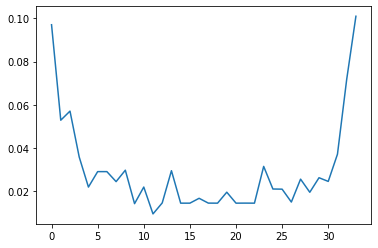

In [90]:
# Calculate the pagerank centrality as described above
diag = np.diag(A.sum(axis=1))
alpha = 0.85
N = 34
A1 = np.eye(N) - ( alpha * (A @ np.linalg.inv(diag)) )
b1 = (1 - alpha)/N * np.ones((N, 1))
pagerank_centrality = np.linalg.solve(A1, b1)
print(pagerank_centrality)
plt.plot(pagerank_centrality);

From this plot I can see that for pagerank centrality the first, second and last nodes are highly central as they have high centrality values compared to the rest of the nodes, this is almost identical to degree centrality.

I will use the following seaborn correlation plots and calculate the Spearmans Rank to show how correlated each of the different centrality measures are:

Spearmans rank coefficient for degree vs eigenvector centrality: 0.7752555221953447
Spearmans rank coefficient for degree vs pagerank centrality: 0.9787753706758103
Spearmans rank coefficient for eigenvector vs pagerank centrality: 0.6749319199221476


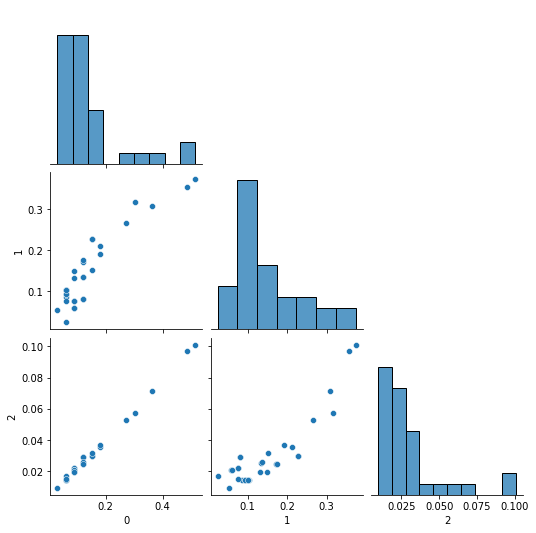

In [91]:
import seaborn as sns
from scipy.stats import spearmanr

# Concatenate the different centralities to create a set of correlation plots between all three
degree_centrality = degree_centrality.reshape((34, 1))
rankings = np.concatenate((degree_centrality, eigenvector_centrality, pagerank_centrality), axis = 1)
rankings1 = pd.DataFrame(rankings)
sns.pairplot(rankings1, corner=True);

# Calculate the Spearmans Rank to assign an actual value to the correlation of these different measures 
deg_ein = spearmanr(rankings1.iloc[:, 0], rankings1.iloc[:, 1])[0]
deg_pr = spearmanr(rankings1.iloc[:, 0], rankings1.iloc[:, 2])[0]
ein_pr = spearmanr(rankings1.iloc[:, 1], rankings1.iloc[:, 2])[0]

print('Spearmans rank coefficient for degree vs eigenvector centrality:', deg_ein)
print('Spearmans rank coefficient for degree vs pagerank centrality:', deg_pr)
print('Spearmans rank coefficient for eigenvector vs pagerank centrality:', ein_pr)

* For degree vs eigenvector centrality, I have a Spearmans Rank coefficient of 0.7752555221953447 which shows that these two centralities are strongly correlated. This is fortified by the top left scatter plot that highlights the correlation between these two measures as there are a fair few shared node centralities
* For degree vs pagerank centrality, I have a Spearmans Rank coefficient of 0.9787753706758103 which shows that these two centralities are almost identical as their correlation is almost 1. This is fortified by the middle scatter plot that shows a lot of shared node centralities
* For eigenvector vs pagerank centrality, I have a Spearmans Rank coefficient of 0.675084965708978 which shows that these two centralities are correlated but are the weakest of the three, which is further shown by the bottom right scatter plot as there are some shared node centralities

### Part 2.3.2

I will use the Clauset-Newman-Moore greedy modularity maximization algorithm (which I will refer to as the greedy modularity algorithm - GMA) which begins with each node in its own community and keeps joining the pair of communities that most increase modularity until no such pair exists, so when this algorithm is finished the data points will all be divided exclusively into different clusters, I obtained this definition from [networkx.algorithms.community.modularity_max.greedy] - see references at the bottom. I will implement this GMA using the inbuilt function in NetworkX by running the following code which will partition the dataset into communities.

In [92]:
# Import required function
from networkx.algorithms.community import greedy_modularity_communities

# Use the inbuilt greedy modularity function
G = nx.karate_club_graph()
c = list(greedy_modularity_communities(G))

#Print the communities given by this function
c0 = sorted(c[0])
c1 = sorted(c[1])
c2 = sorted(c[2])

print('Community 1 is:', c0, 'this has size:' , len(c[0]))
print('Community 2 is:', c1, 'this has size:' , len(c[1]))
print('Community 3 is:', c2, 'this has size:' , len(c[2]))

Community 1 is: [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] this has size: 17
Community 2 is: [1, 2, 3, 7, 9, 12, 13, 17, 21] this has size: 9
Community 3 is: [0, 4, 5, 6, 10, 11, 16, 19] this has size: 8


From this it is clear to see that the optimal number of communities is k* = 3 as the GMA has stopped running and outputted three different communities.

To be able to visualise this properly, I will plot these obtained clusters on a graph and assign a different colour to each community so we can better understand this clustering.  In order to do this I will now assign labels to the nodes in the following way:
* Nodes in community 1 have the label: 'comm1'
* Nodes in community 2 have the label: 'comm2'
* Nodes in community 3 have the label: 'comm3'

In [93]:
# Adding a label to certain nodes as explained above
for i in c0:
    G.nodes[i]['label'] = 'comm1'
for i in c1:
    G.nodes[i]['label'] = 'comm2'
for i in c2:
    G.nodes[i]['label'] = 'comm3'
G.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi', 'label': 'comm3'}, 1: {'club': 'Mr. Hi', 'label': 'comm2'}, 2: {'club': 'Mr. Hi', 'label': 'comm2'}, 3: {'club': 'Mr. Hi', 'label': 'comm2'}, 4: {'club': 'Mr. Hi', 'label': 'comm3'}, 5: {'club': 'Mr. Hi', 'label': 'comm3'}, 6: {'club': 'Mr. Hi', 'label': 'comm3'}, 7: {'club': 'Mr. Hi', 'label': 'comm2'}, 8: {'club': 'Mr. Hi', 'label': 'comm1'}, 9: {'club': 'Officer', 'label': 'comm2'}, 10: {'club': 'Mr. Hi', 'label': 'comm3'}, 11: {'club': 'Mr. Hi', 'label': 'comm3'}, 12: {'club': 'Mr. Hi', 'label': 'comm2'}, 13: {'club': 'Mr. Hi', 'label': 'comm2'}, 14: {'club': 'Officer', 'label': 'comm1'}, 15: {'club': 'Officer', 'label': 'comm1'}, 16: {'club': 'Mr. Hi', 'label': 'comm3'}, 17: {'club': 'Mr. Hi', 'label': 'comm2'}, 18: {'club': 'Officer', 'label': 'comm1'}, 19: {'club': 'Mr. Hi', 'label': 'comm3'}, 20: {'club': 'Officer', 'label': 'comm1'}, 21: {'club': 'Mr. Hi', 'label': 'comm2'}, 22: {'club': 'Officer', 'label': 'comm1'}, 23: {'club': 'Officer', 

We can clearly see that each node has been assigned a label based on what community the GMA put them in, with this I am now able to use NetworkX to create the desired graph described above:

['comm3', 'comm2', 'comm2', 'comm2', 'comm3', 'comm3', 'comm3', 'comm2', 'comm1', 'comm2', 'comm3', 'comm3', 'comm2', 'comm2', 'comm1', 'comm1', 'comm3', 'comm2', 'comm1', 'comm3', 'comm1', 'comm2', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1', 'comm1']
[2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


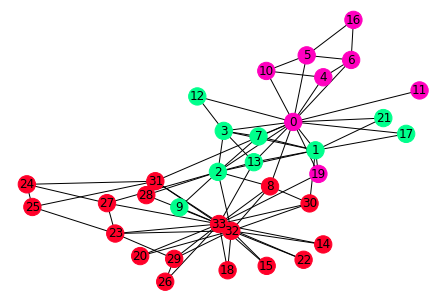

In [94]:
# Get the community labels for each node
node_community = list(nx.get_node_attributes(G, 'label').values())
print(node_community)

# Using list comprehension to assign community labels
node_community_id = [0 if label=='comm1' else 1 if label=='comm2' else 2 for label in node_community]
print(node_community_id)

# Use networkx to draw a graph (colour map) using these labels and assign a different colour for each community
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=node_community_id, with_labels = True, cmap=plt.cm.gist_rainbow)

The graph above shows each node and the community they belong to based on what colour they are.

Now to take this further, I will consider the distribution of the top 8 node centralities and see which communities they are in. I will first start by consider the top 8 node centralities according to degree centrality.

In [106]:
# Use argsort to obtain the top 8 values in my degree centrality vector
degree_centrality = degree_centrality.reshape((34, ))
top8_dc = np.argsort(degree_centrality)[-8:]
top8_dc = np.flip(top8_dc)

# Use a loop to output these and print what community they are in
print(top8_dc)
for i in range(8):
    print('Node', i, 'is in:', node_community[top8_dc[i]])

[33  0 32  2  1 31  3 23]
Node 0 is in: comm1
Node 1 is in: comm3
Node 2 is in: comm1
Node 3 is in: comm2
Node 4 is in: comm2
Node 5 is in: comm1
Node 6 is in: comm2
Node 7 is in: comm1


We see that we have the top 8 nodes according to degree centrality are distributed in the following way:
- 4 nodes in community 1
- 3 nodes in community 2
- 1 node in community 3 

This distribution can be very simplify represented by the following bar chart:

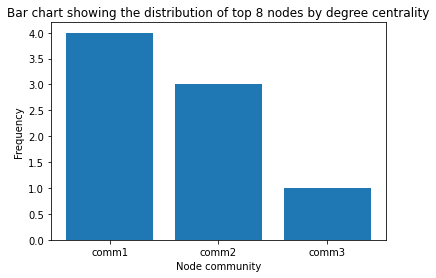

In [336]:
# Define the communities and the frequency according to the distribution above and plot the bar chat
communities = ['comm1', 'comm2', 'comm3']
frequency = [4, 3, 1]
plt.bar(communities, frequency);
plt.title('Bar chart showing the distribution of top 8 nodes by degree centrality');
plt.xlabel('Node community');
plt.ylabel('Frequency');

 I will do the same thing again but now consider the top 8 node centralities according to pagerank centrality.

In [194]:
pagerank_centrality = pagerank_centrality.reshape((34, ))
top8_pr = np.argsort(pagerank_centrality)[-8:]
top8_pr = np.flip(top8_pr)
print(top8_pr)
for i in range(8):
    print('Node', i, 'is in:', node_community[top8_pr[i]])

[33  0 32  2  1 31  3 23]
Node 0 is in: comm1
Node 1 is in: comm3
Node 2 is in: comm1
Node 3 is in: comm2
Node 4 is in: comm2
Node 5 is in: comm1
Node 6 is in: comm2
Node 7 is in: comm1


We see that we have the top 8 nodes according to PageRank centrality are distributed in same way as before, which is as follows:
- 4 nodes in community 1
- 3 nodes in community 2
- 1 node in community 3 


This distribution can be very simplify represented by the following bar chart:

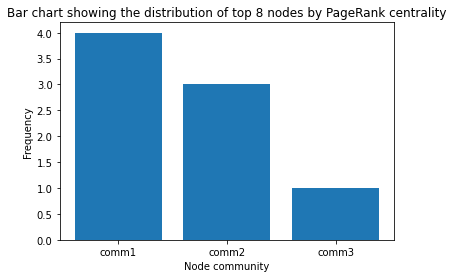

In [335]:
# Define the communities and the frequency according to the distribution above and plot the bar chat
communities = ['comm1', 'comm2', 'comm3']
frequency = [4, 3, 1]
plt.bar(communities, frequency);
plt.title('Bar chart showing the distribution of top 8 nodes by PageRank centrality');
plt.xlabel('Node community');
plt.ylabel('Frequency');

I can see that the distribution of the top 8 node centralities are the exact same according to the degree and pagerank centrality measures, this is expected because they are almost identical as shown by their Spearmans Rank coefficient of 0.9787753706758103 and so it is natural they distribute the top 8 node centralities in the same way.

### Part 2.3.3

I will now define the Adjusted Rand Index (ARI) score, which I will use to get an idea of the similarity/correlation between two data clusterings, this is the corrected-for-chance version of Rand Index. I researched the ARI to further understand it using [The Adjusted Rand index - Dave Tang's blog] - see references at the bottom, but used the formula/definition from the lecture notes.

Before I calculate the ARI, I need to define my own n choose 2 function that allows me to apply it to matrices, as the standard inbuilt combinatorics function cannot do this:

In [112]:
# We will import the in-built combinatorics function 'comb' from the scipy module for the following two functions
from scipy.special import comb

# We need to define an n choose 2 function that applies element-wise to matrix entries 
def nc2_matrix(m1):
    # Make a zeros deep copy of A which we contain the entries of A after applying nC2 to each entry
    m2 = 0.0 * m1
    k_A, k_B = m1.shape
    for i in range(k_A):
        for j in range(k_B):
            m2[i, j] = comb(m1[i, j], 2)
    return m2

Now using my 'nc2_matrix()' function I will define a function that finds the ARI based on the formula given above:

In [118]:
def Adj_Rand_Index(C_A, C_B):
    
    # Get the correct data type and use max to get the number of different truth values
    C_A = C_A.astype('int64')
    C_B = C_B.astype('int64')
    k_A = max(C_A) + 1
    k_B = max(C_B) + 1
    
    # Preallocate contingency matrix - it has entries n_ij which is the co-occurences which is number of times 
    # an element occurs in cluster i of X AND cluster j of Y
    cont_matrix = np.zeros((k_A, k_B))
    for i in range(34):
        for j in range(k_A):
            for k in range(k_B):
                if C_A[i] == j and C_B[i] == k:
                    cont_matrix[j, k] += 1                                
                        
    # Calculate the values we need to put into the ARI formula given above
    S_n = np.sum(nc2_matrix(cont_matrix))

    a_ij = [sum(cont_matrix[i]) for i in range(k_A)]
    # Made into an array and changed shaped from (k_A, ) to (k_A, 1)
    a_ij = np.array(a_ij)
    a_ij = a_ij.reshape((k_A, 1))
    S_a = sum(nc2_matrix(a_ij))

    b_ij = [sum(cont_matrix[:, i]) for i in range(k_B)]
    # Made into an array and changed shaped from (k_B, ) to (k_B, 1)
    b_ij = np.array(b_ij)
    b_ij = b_ij.reshape((k_B, 1))
    S_b = sum(nc2_matrix(b_ij))

    ARI = (S_n - (S_a @ S_b) / comb(34, 2)) / (0.5 * (S_a + S_b) - (S_a @ S_b) / comb(34, 2))
    return ARI

I will first import our real-life acrimonious split which I will refer to as the truth labels, from a microsoft excel spreadsheet using csv.reader:

In [114]:
# Import and define our truth labels
import csv

g = csv.reader(open("ground_truth_karate_club1.csv", "r"), delimiter=",")
g = list(g)

label_truth = np.zeros((34,))
for i in range(34):
    if g[i][0] == 'Mr. Hi':
        label_truth[i] = 1
print(label_truth)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now, I will take my optimal clusters obtained in 2.1.2 through k-means clustering and define this as label 1:

In [115]:
#Label 1
label_KMC = k_means_clustering(2)[1]
print(label_KMC)

[1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0]


Finally, I will take my optimal clusters obtained in 2.3.2 through node communities and define this as label 2:

In [116]:
#Label 2
node_community_id = np.array(node_community_id)
label_GNC = node_community_id.reshape((34, ))
print(label_GNC)

[2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


Now, I will use my ARI function on these three labels to assign a numerical value to the similarity between two data clusterings, I found the ARI between each of the three labels and outputted them:

In [117]:
# Find the ARI between each of the three labels and check to make sure they are symmetric so that my function is working 
print(Adj_Rand_Index(label_truth, label_KMC))
print(Adj_Rand_Index(label_KMC, label_truth))
print(Adj_Rand_Index(label_truth, label_GNC))
print(Adj_Rand_Index(label_GNC, label_truth))
print(Adj_Rand_Index(label_KMC, label_GNC))
print(Adj_Rand_Index(label_GNC, label_KMC))

[0.00129702]
[0.00129702]
[0.56843941]
[0.56843941]
[-0.03148701]
[-0.03148701]


From this we see that:
* The truth label and label 1 have almost no similarity and they seem to have a miniscule positive correlation this shows that k-means clustering is very poor at clustering the dataset in a way that actually happened in real life.
* The truth label and label 2 have by far the similarity and they have strongest correlation this shows that the GMA is quite good at clustering the dataset in a way that actually happened in real life.
* The label 1 and label 2 have almost no similarity but they seem to have a very slight negative correlation, this shows little agreement between k-means clustering and the GMA.

It seems from this that the GMA is the superior method of clustering data points out of GMA and k-means clustering

## References

- [Glorot initialisation] - link: http://proceedings.mlr.press/v9/glorot10a.html
- [Data Normalization or Feature Scaling] - link: https://en.wikipedia.org/wiki/Feature_scaling
- [Elbow method (clustering)] - link: https://en.wikipedia.org/wiki/Elbow_method_(clustering)
- [Calinski-Harabasz Index – Cluster Validity indices] - link: https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/
- [networkx.algorithms.community.modularity_max.greedy] - link: https://networkx.org/documentation/networkx-2.2/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html
- [The Adjusted Rand index - Dave Tang's blog] - link: https://davetang.org/muse/2017/09/21/adjusted-rand-index/